In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle


import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_90k_tns_df.csv', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_90-10.csv.gz', compression='gzip', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_85-15.csv.gz', compression='gzip', index_col='ztf_object_id')
dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_80-20.csv.gz', compression='gzip', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_80-20_addJiterNorm0p1.csv.gz', compression='gzip', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_80-20_addJiterNorm0p05.csv.gz', compression='gzip', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_80-20_addJiterNorm0p02.csv.gz', compression='gzip', index_col='ztf_object_id')
#dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_80-20_addJiterNorm0p01.csv.gz', compression='gzip', index_col='ztf_object_id')


dataset_bank_tns_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19ackimld,0.193100,-0.307408,0.400000,0.000000,0.253017,0.386200,0.355100,0.147900,-0.405911,0.000503,...,0.035700,-0.110800,-0.124800,-0.172100,75.583421,2.088205,No_TNS,None,-99.0,None
ZTF20acoxdas,0.627042,-0.186492,0.333333,0.000000,0.408828,1.254084,1.060876,0.757065,-0.677916,0.018984,...,0.568499,0.698500,0.668100,0.216900,12.467979,0.943354,Yes_TNS,SN Ia,0.1,ALeRCE
ZTF20acibvgy,0.182631,-0.574715,0.200000,0.000000,0.394121,0.365263,0.365263,0.219012,0.326944,0.017688,...,0.660299,0.908699,0.736700,0.528099,71.406949,0.326222,Yes_TNS,None,-99.0,ALeRCE
ZTF20acbrlih,0.386832,-0.256474,0.461538,0.000000,0.402720,0.773664,0.765432,0.572464,-1.158863,-0.001732,...,0.724899,0.823900,0.538300,0.744900,55.308887,0.434827,Yes_TNS,None,-99.0,Pan-STARRS
ZTF19aadfqfw,0.868800,-0.199488,0.333333,0.000000,0.422124,1.737600,1.714910,1.510700,-1.395242,-0.103710,...,1.252501,1.324600,1.435499,1.297100,1.605507,0.394891,Yes_TNS,None,-99.0,ZTF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaxsowb,0.070928,-0.351747,0.200000,0.000000,0.305973,0.141855,0.141855,0.092972,-0.246354,0.005672,...,0.960799,0.944100,1.015100,1.232200,69.743472,0.422087,Yes_TNS,None,-99.0,ALeRCE
ZTF21aapkuur,0.106760,-0.744001,0.400000,0.000000,0.378529,0.213520,0.213520,0.128711,-0.074463,0.010770,...,0.028999,0.152800,0.133600,0.009901,46.527568,0.063019,Yes_TNS,SN Ia,0.1,Pan-STARRS
ZTF21aaxhveb,0.528692,-0.107271,0.300000,0.000000,0.425558,1.057384,0.937274,0.773542,-1.095850,0.025321,...,0.525501,0.609900,0.615601,0.650200,19.159718,1.140695,Yes_TNS,None,-99.0,ALeRCE


### Both noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_80-20 and noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20 are good (hostdownweighted maybe sliiightly better)

### suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p2_SMOTE_80-20" is nearly if not as good as hostdownweighted


In [3]:
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_sep_highlighted_SMOTE_90-10" # could be ok
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_sep_highlighted_SMOTE_80-20"


#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_direct_output_SMOTE_90-10" # not great
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_direct_output_SMOTE_80-20"


#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_90-10" # decent
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_80-20" # eh
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_80-20" # second best to hostdownweighted



#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_90-10" # decent but hard to say
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_85-15" # decent; better than 90-10
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #The best i think

#suffix="noTNScut_pca5_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #not good. more degenerate with only 5pcs. 65% var
#suffix="noTNScut_pca10_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #not bad. 80% var
#suffix="noTNScut_pca15_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #decent. 86% var
#suffix="noTNScut_pca25_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #p close to noPCA but slightly worse (less self reference classes)
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really good, better than 25pca
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really v good[!] better than 35pca (best PC implementation)
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" # decent but not as good as manhattan distance (above)

# same PCs but different scalers and/or metrics
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really v good, better than 35pca (best PC implementation)
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # decent but not amazing. 99% var
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" # awful (similarity match). AD is ok... 99% var

#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_hamming" #not that good.
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #decent. Worth trying with other scalers.
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_dot" #SS not good. always matches to None lol.


# manhattan
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really v good[!] better than 35pca (best PC implementation)
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # decent but not amazing. 99% var
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MinMax_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # great Sim Search. less great AD (but ok)
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # Best one! great Sim Search. great AD[!] might be best one!
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_RobustS-25-75_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # fine, but not as good as MaxAbs or SS

# euclidean
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" # decent but not as good as manhattan distance (above)
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" # awful (similarity match). AD is ok... 99% var
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MinMax_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" # decent Sim Search. decent AD but others are better
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" # pretty bad
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_RobustS-25-75_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_euclidean" #decent but others are better


# angular
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #decent. Worth trying with other scalers.
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #ok but not great.
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MinMax_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #eh Sim Search. Good AD[!]
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #eh Sim Search. bad AD.
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_RobustS-25-75_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #eh Sim Search. awful AD 


# BEST AD OPTIONS for PCA
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # Best one! great Sim Search. great AD[!] might be best one!
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really v good[!] better than 35pca (best PC implementation)
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MinMax_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_angular" #eh Sim Search. Good AD[!]

# trying
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p1" # too big. need smaller jitter. 98% var
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p05" # too big. need smaller jitter. 98% var. 
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p02" # 95% var. PC plots look good. Not great but jitter spread is more realistic
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p01" # 95% var. PC plots look better. Not great but jitter is more realistic

suffix="noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_80-20" # amazing sim search. 99%var. AD is quite good, maybe 2nd or 3rd best. Maybe overall best when considering both!


# best in AD going down in PCs
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # Best one! great Sim Search. great AD[!] might be best one! 99% var
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # !! Really nice. Same/better results with less PCs. 98% var.
#suffix="noTNScut_pca25_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # Not bad but losing steam from higher PCs. 97% var
#suffix="noTNScut_pca15_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # about as good as 25 PCs. 93% var
#suffix="noTNScut_pca10_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # Not bad but losing steam from higher PCs. 87% var
#suffix="noTNScut_pca5_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # 71% var. really falls off

#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_NOfw_SMOTE_80-20" # decent but maybe not the best
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_direct_output_SMOTE_80-20" # ok but not amazing
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_host2p0_SMOTE_80-20" # decent. but galaxies basically play no factor
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_host0p2_SMOTE_80-20" # eh sim search. not awful AD
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_80-20" # awful sim search. bad


#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_90-10" # eh
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_85-15" # better than hostdownweighted 85-15
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_80-20" # good. slightly worse than hostdownweighted_SMOTE_80-20
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p008_SMOTE_80-20" # not as good as hostdownweighted


#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p2_SMOTE_80-20" # 
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_host0p2_SMOTE_80-20" # decent, but hostdownweighted is the best







#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_SMOTE_90-10"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_SMOTE_85-15" # tied second best
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_SMOTE_80-20" # tied second best



#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_direct_output_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_sep_highlighted_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_sep_highlighted_SMOTE"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_sep_highlighted"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_LConly"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_noSS_AlerceCls_fw_MI_classif_LConly"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_noSS_AlerceCls_fw_MI_classif_only2"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_MI_classif_only"
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_MI_classif_highlight_sepFs"
#suffix=f"noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_fromDict"

ann_num = 350
col_list= [f'dist={col}' for col in range(1, ann_num)]
dist_col = f'Max-{len(col_list)}ANNs'


ann_dist_all_df = pd.read_csv(f'ann_dist_all_df_{suffix}_ann_num={ann_num}.csv', index_col=0)
ann_dist_all_df.index = ann_dist_all_df.index.rename('ztf_object_id')
ann_dist_all_df

,Mean-349ANNs,Max-349ANNs
ztf_object_id,,
ZTF17aadqidc,47.785882,49.771206
ZTF18aadlaxo,46.133443,49.613811
ZTF18aahsuyl,38.876223,39.751625
ZTF18aaisqmw,67.269694,70.137779
ZTF18aajgowk,53.073076,55.400833
...,...,...
ZTF21aciuhqw,49.878476,50.786293
ZTF21acjgpvq,66.021516,69.383553
ZTF21acjjyvv,49.941889,51.569592


In [4]:
merge_df = pd.concat([ann_dist_all_df, dataset_bank_tns_df], axis=1)
merge_df = merge_df[~merge_df.isnull().any(axis=1)]
merge_df

,Mean-349ANNs,Max-349ANNs,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aadqidc,47.785882,49.771206,0.118791,-0.558108,0.428571,0.000000,0.385504,0.237581,0.223594,0.138365,...,0.163198,0.160099,0.150101,0.122200,26.155457,0.051662,No_TNS,None,-99.000000,None
ZTF18aadlaxo,46.133443,49.613811,0.400349,-0.333744,0.111111,0.333333,0.379893,0.800697,0.648489,0.327314,...,0.774100,0.759600,0.756000,0.753699,62.022695,0.036486,Yes_TNS,SN Ia,0.052953,ZTF
ZTF18aahsuyl,38.876223,39.751625,0.456472,-0.436415,0.227273,0.000000,0.407459,0.912945,0.746155,0.433327,...,0.466700,0.441700,0.474998,0.291601,38.796355,0.199907,Yes_TNS,None,-99.000000,ALeRCE
ZTF18aaisqmw,67.269694,70.137779,0.526477,-0.165949,0.400000,0.000000,0.297334,1.052954,0.822551,0.523870,...,0.728600,0.708699,1.092200,0.573000,627.387102,0.209814,Yes_TNS,SN Ia,0.052700,ZTF
ZTF18aajgowk,53.073076,55.400833,0.276666,-0.502600,0.285714,0.000000,0.314073,0.553331,0.481705,0.174625,...,0.287199,0.198200,0.390800,0.351900,33.862239,0.133331,No_TNS,None,-99.000000,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aciuhqw,49.878476,50.786293,0.670816,0.405011,0.150000,0.223607,0.349629,1.341633,0.783248,0.277588,...,0.897000,0.937399,0.836400,0.902900,67.693626,1.141200,Yes_TNS,SN Ic-BL,0.045000,ZTF
ZTF21acjgpvq,66.021516,69.383553,0.158735,-0.929649,0.250000,0.000000,0.304177,0.317471,0.317471,0.241176,...,0.392099,0.417099,0.431299,0.321301,11.002277,0.368490,Yes_TNS,None,-99.000000,ALeRCE
ZTF21acjjyvv,49.941889,51.569592,0.213072,-0.259193,0.375000,0.000000,0.430375,0.426144,0.397676,0.281398,...,0.791101,0.798100,0.678598,0.705400,37.204278,1.176775,Yes_TNS,None,-99.000000,Pan-STARRS


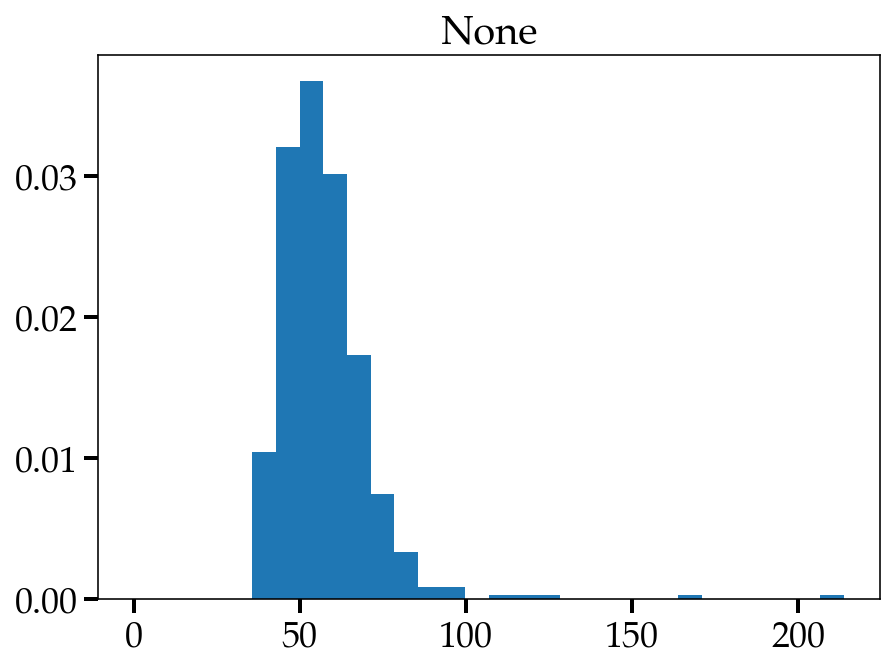

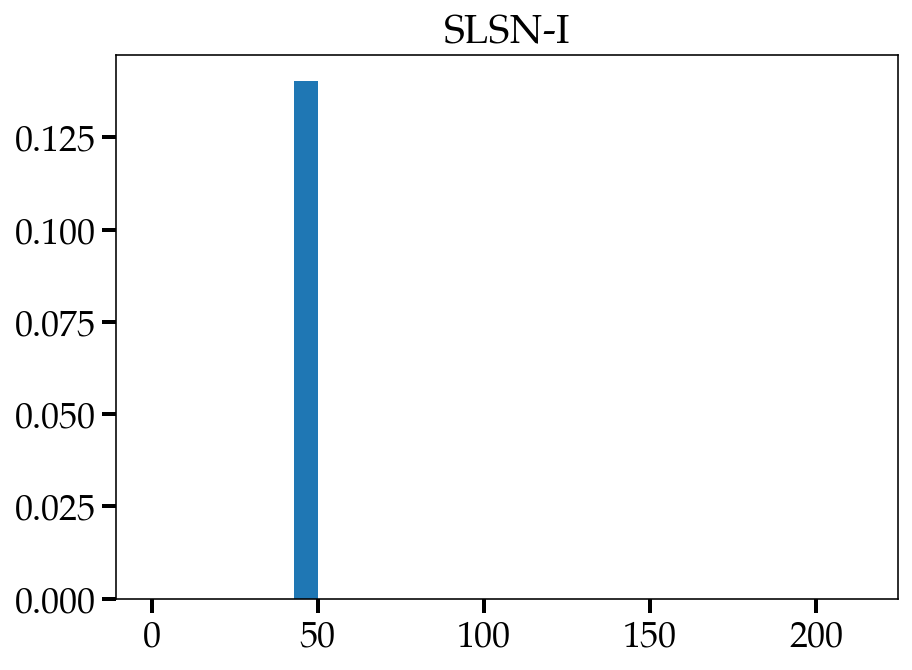

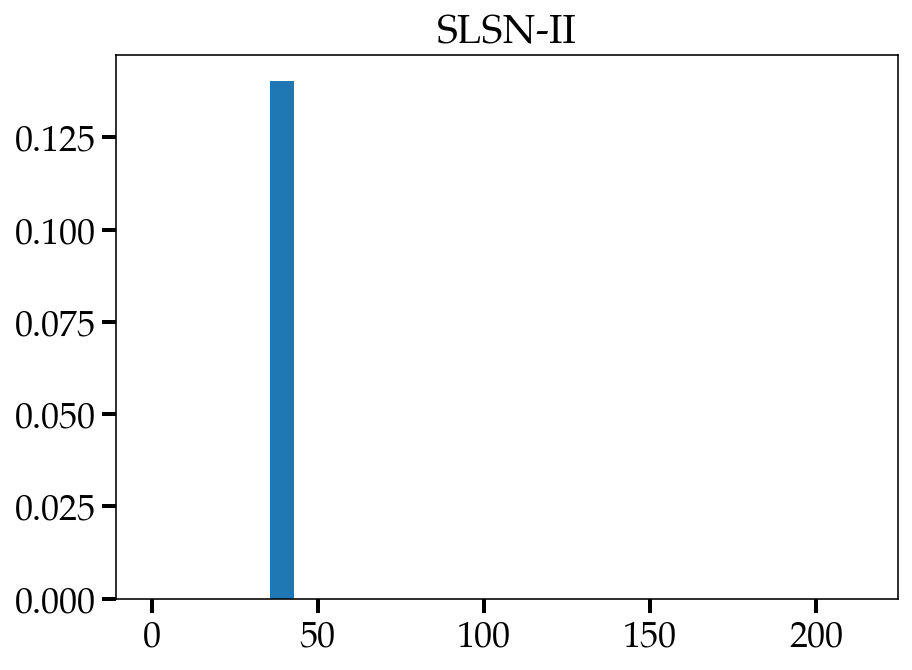

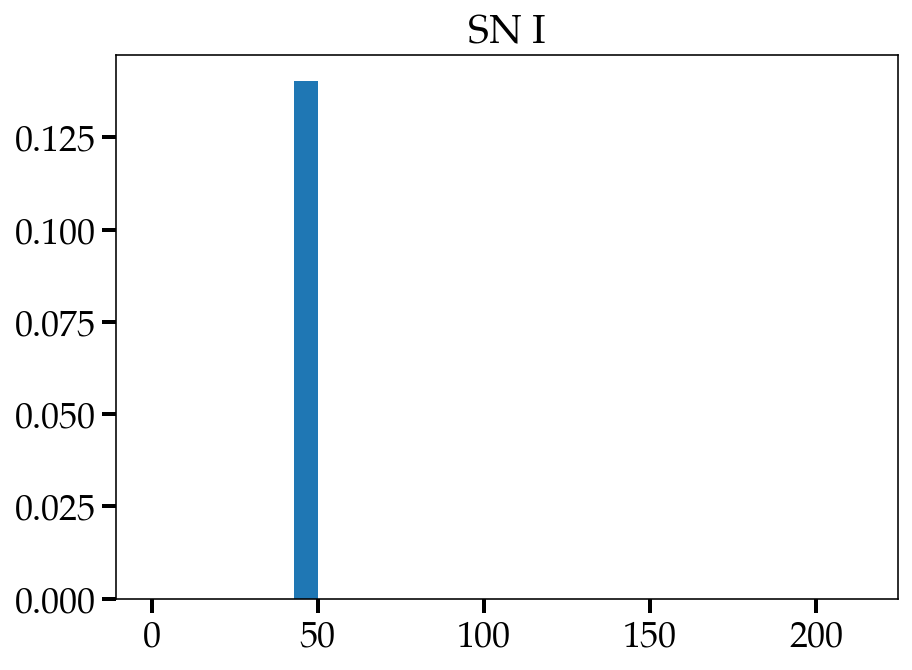

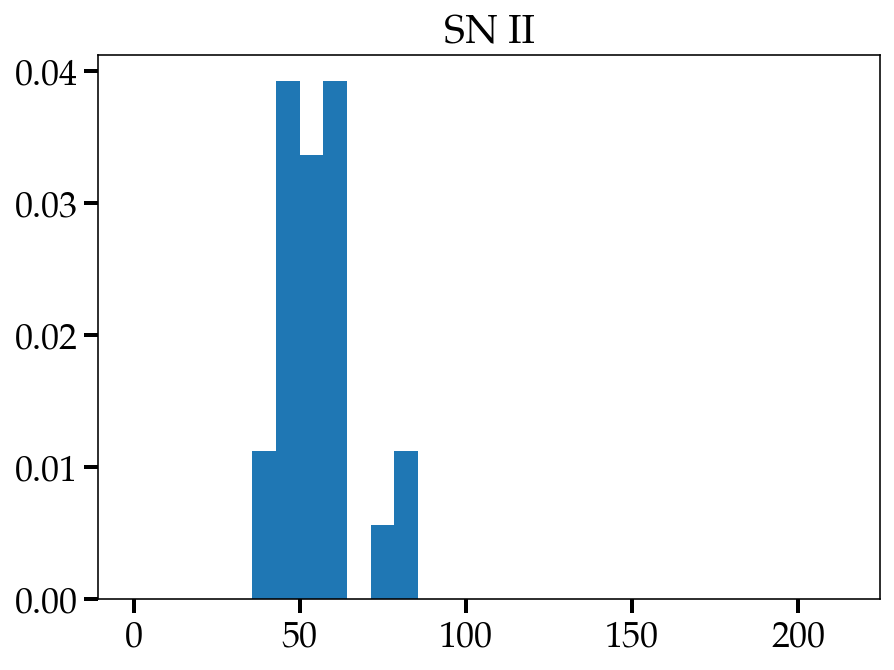

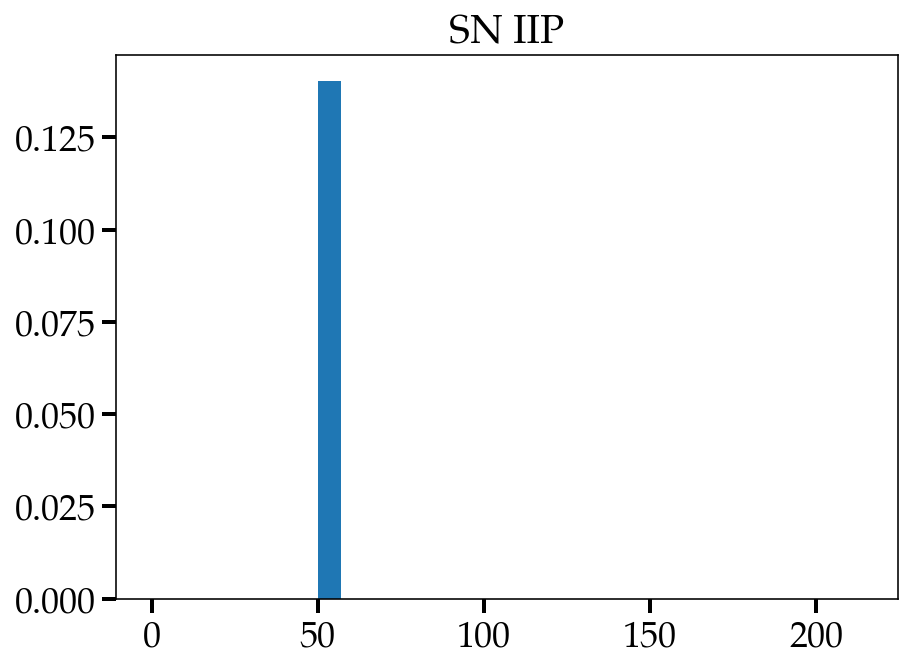

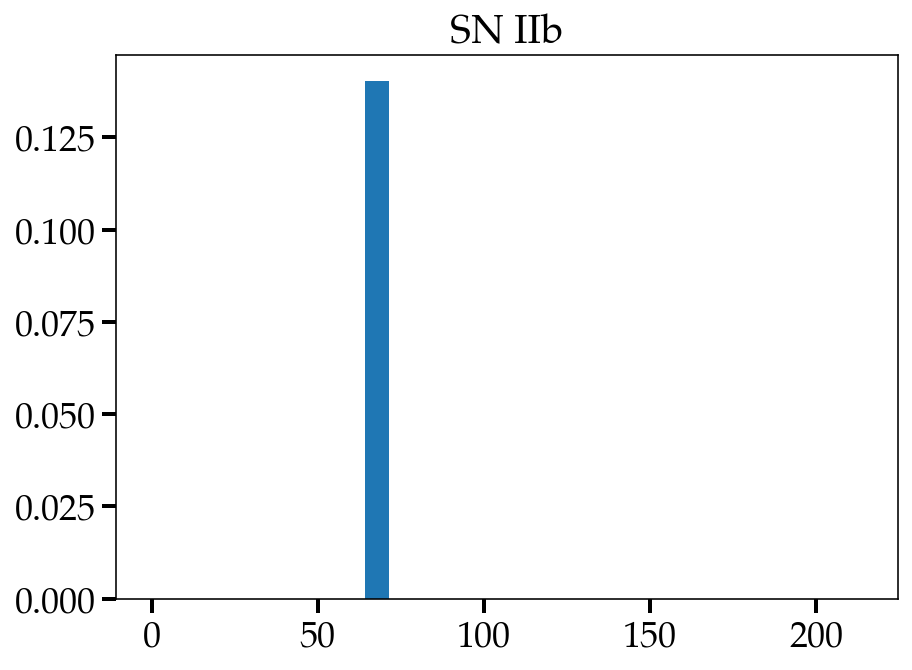

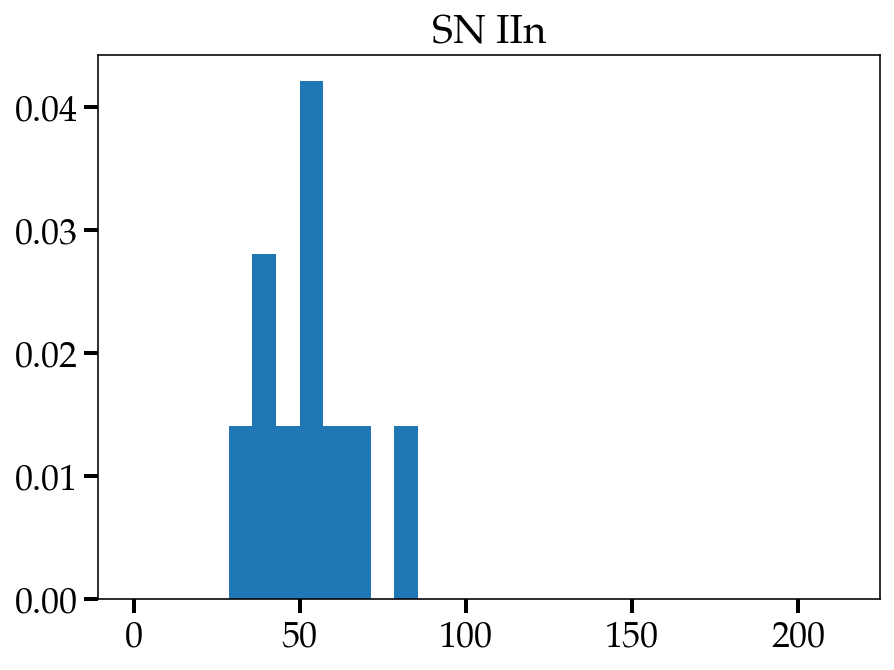

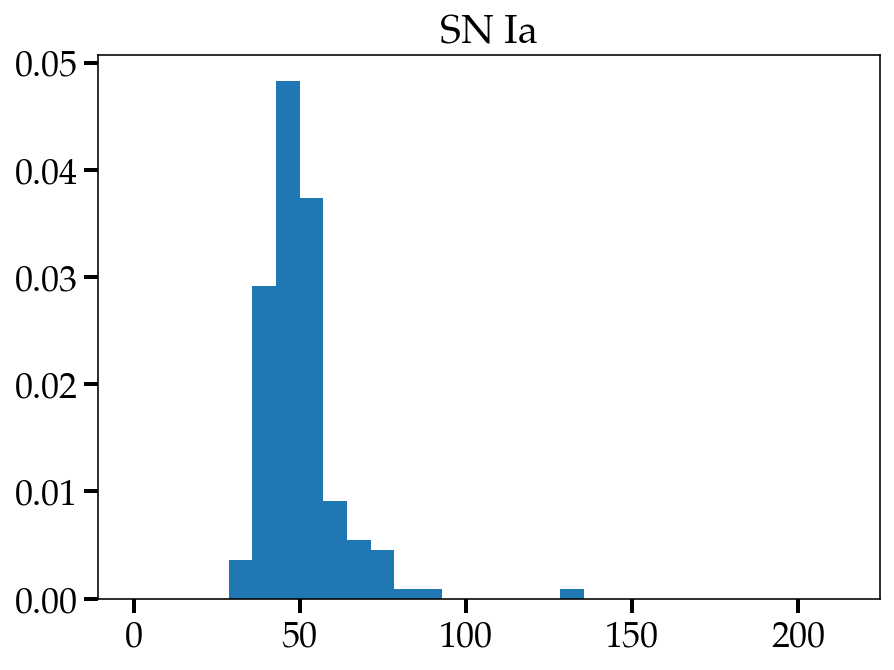

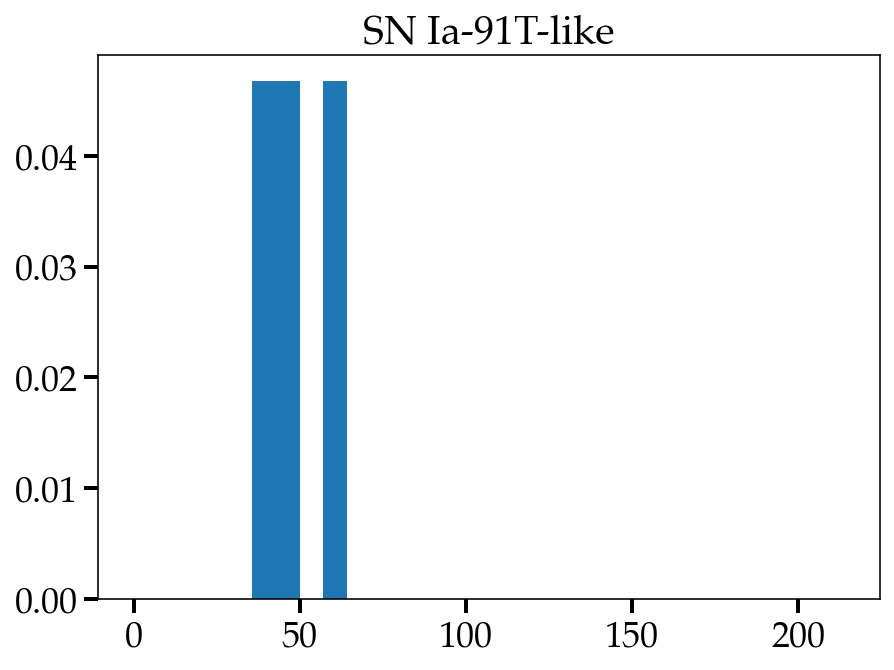

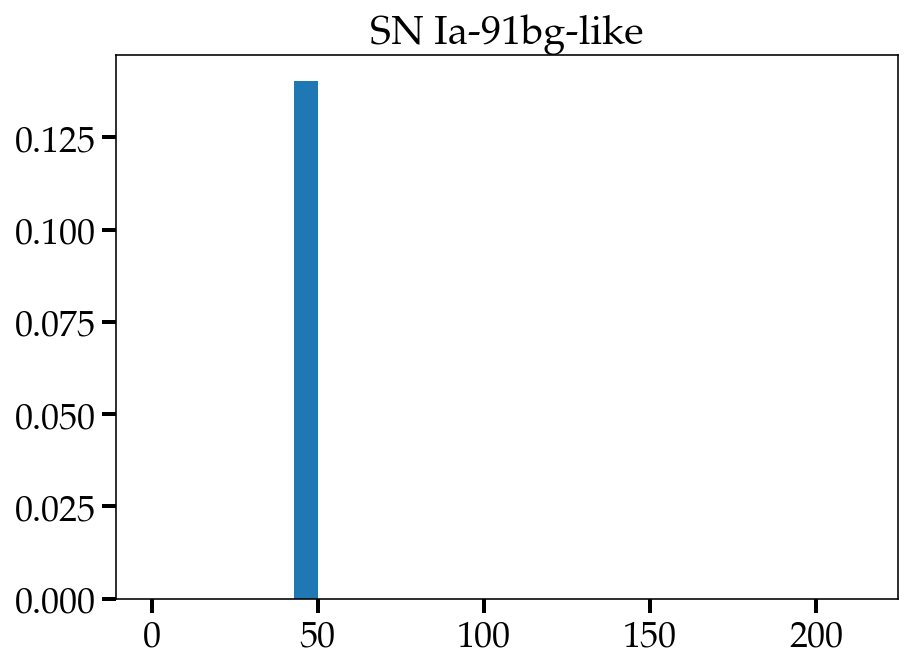

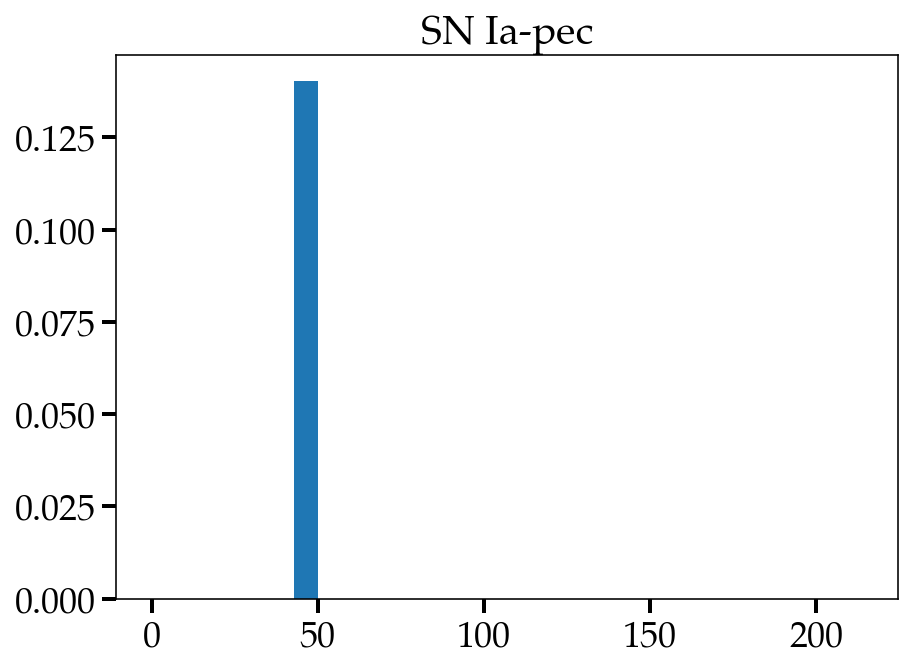

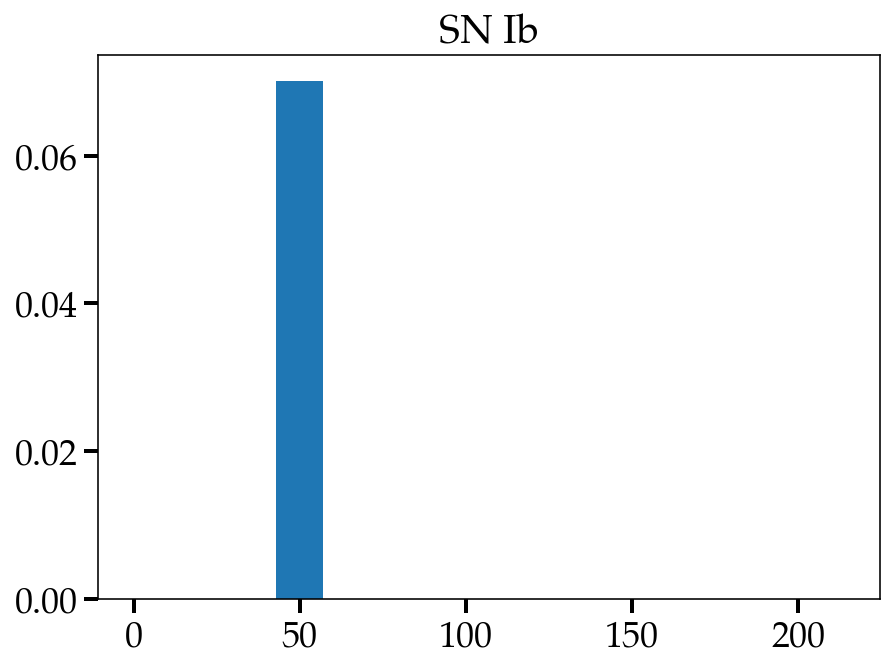

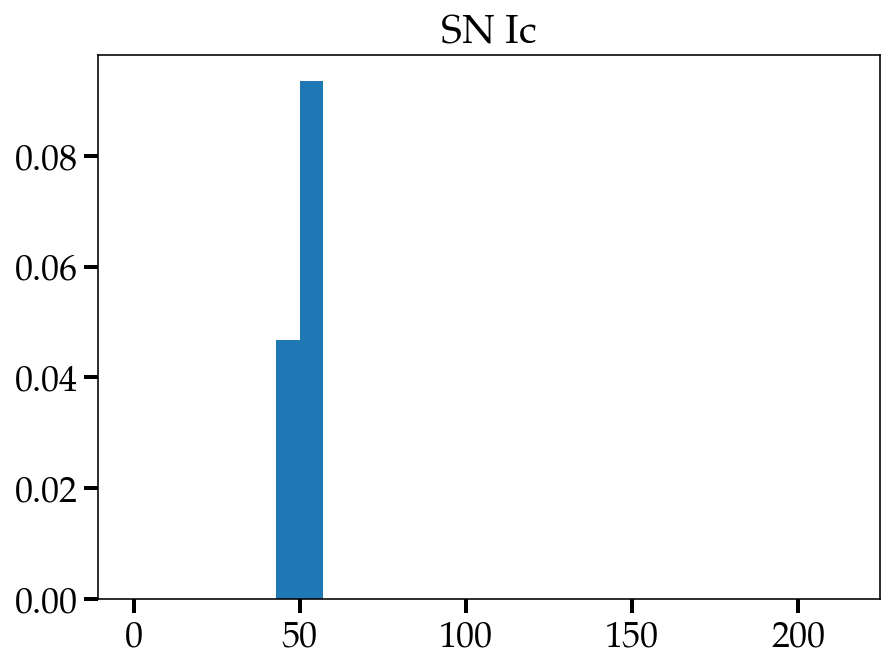

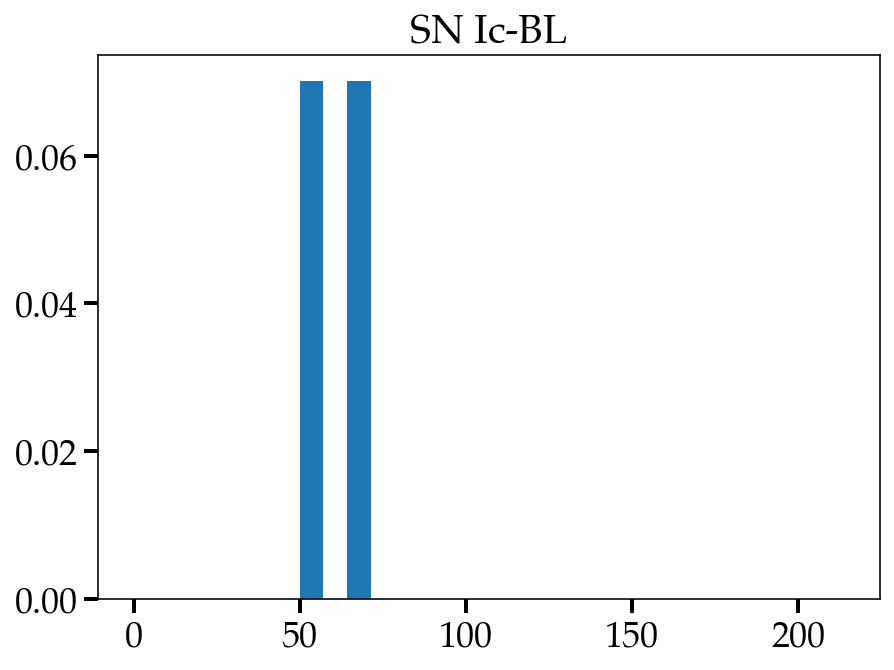

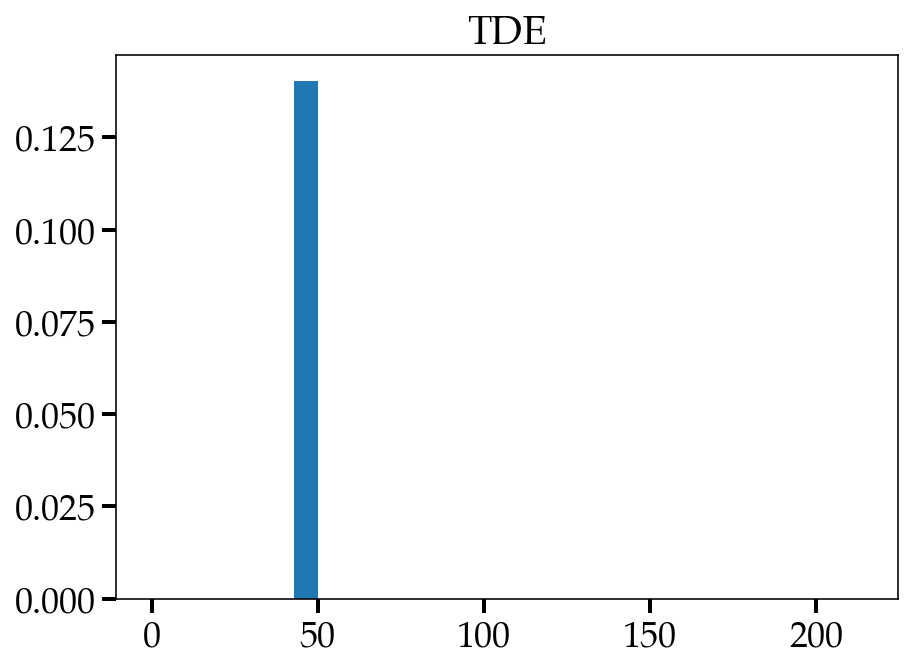

In [5]:
for cls in np.unique(merge_df.tns_cls):
    fig, ax = plt.subplots()
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    #ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, np.max(merge_df["WeightedMean-9ANNs"]), 31), density=True)
    ax.hist(merge_df_cls[dist_col], bins=np.linspace(0, np.max(merge_df[dist_col]), 31), density=True)
    
    ax.set_title(cls)
    #ax.set_xlim(0, 150)

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


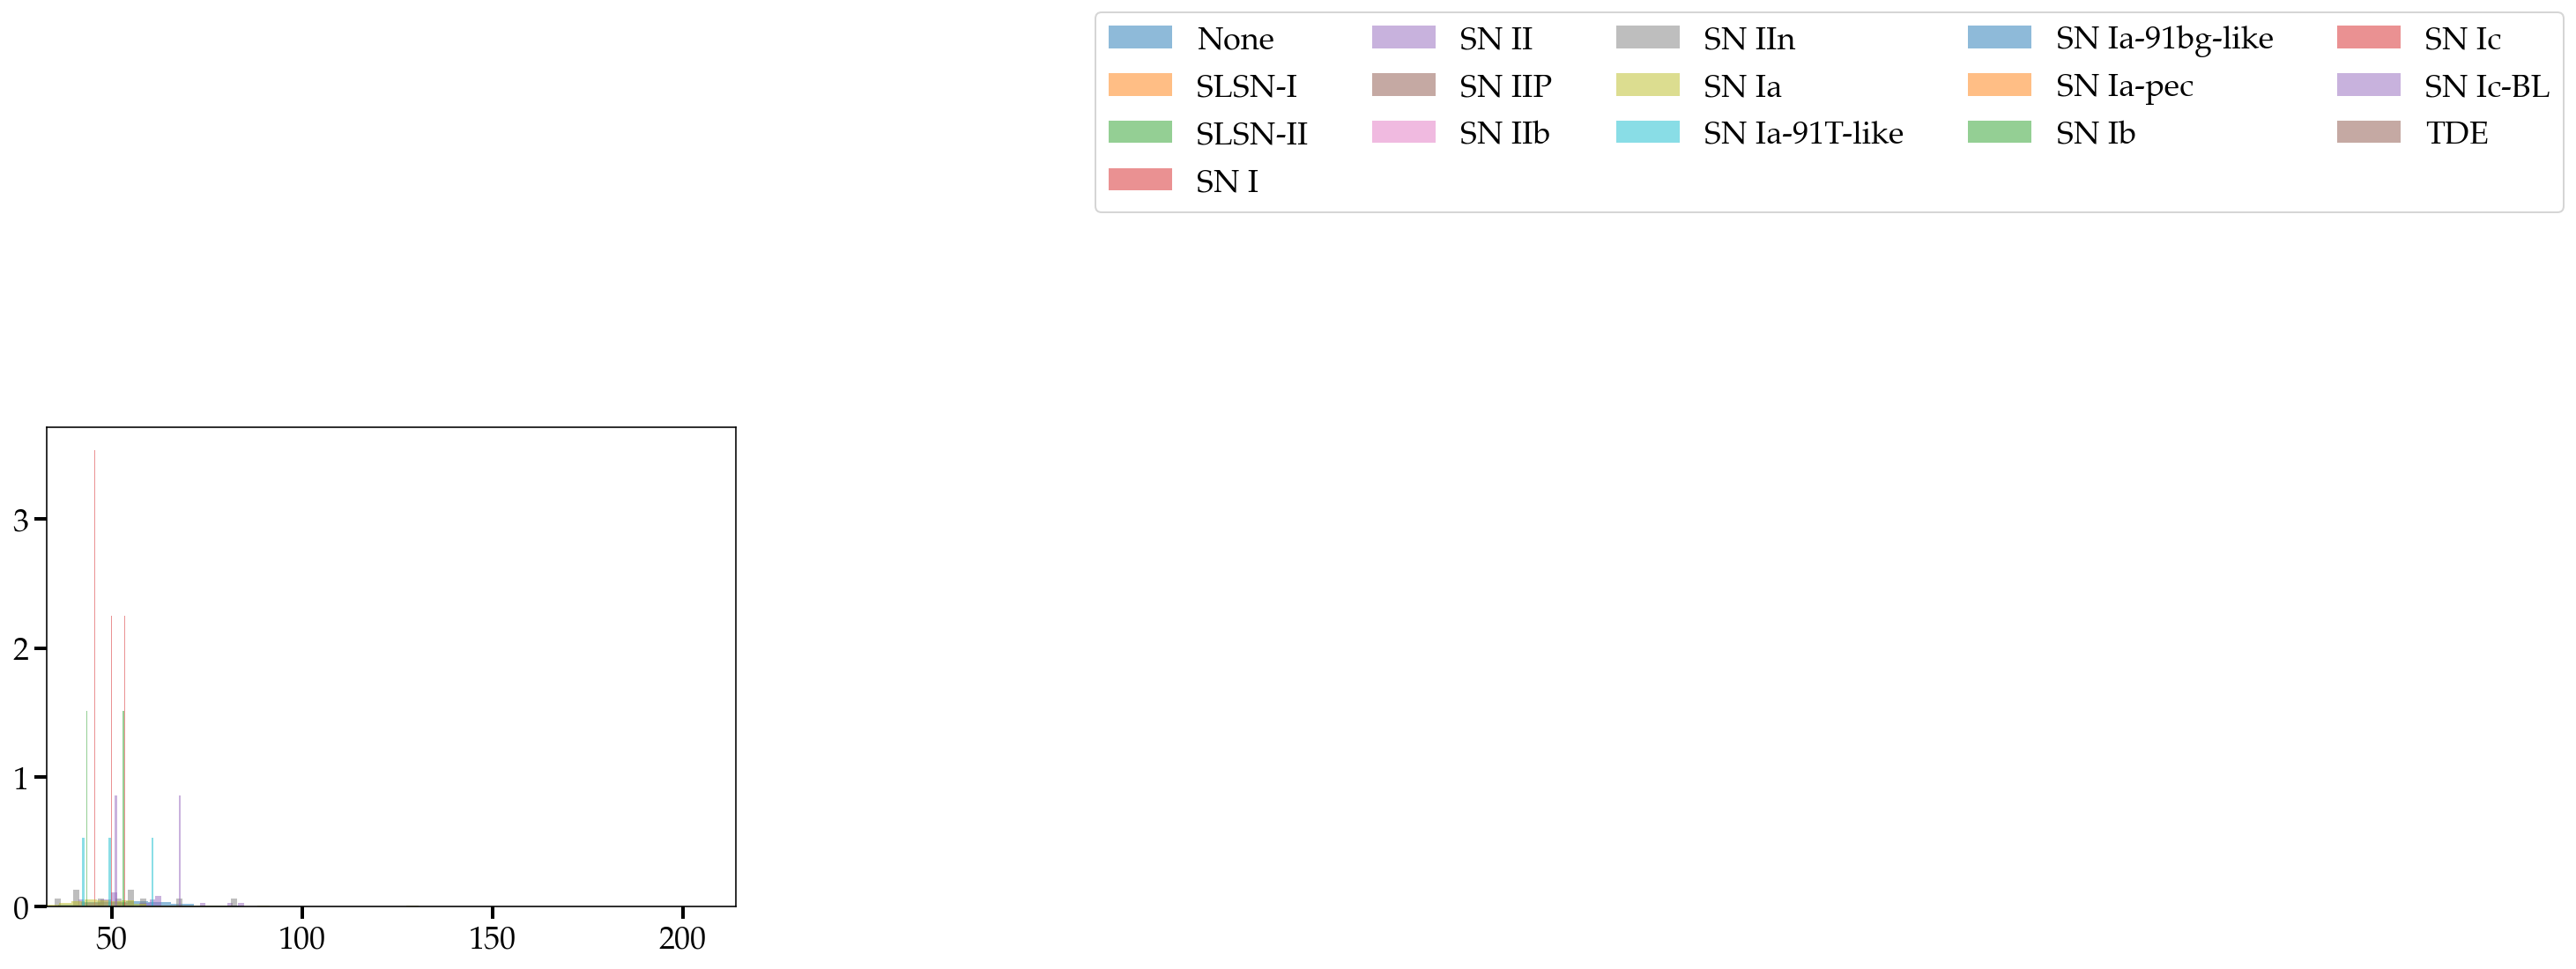

In [6]:
fig, ax = plt.subplots()

for cls in np.unique(merge_df.tns_cls):
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    #ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, 150, 31), 
    #        density=True, alpha=0.5, label=cls)
    
    ax.hist(merge_df_cls[dist_col], bins=np.linspace(np.min(merge_df_cls[dist_col]), np.max(merge_df_cls[dist_col]), 31), 
            density=True, alpha=0.5, label=cls)
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
plt.legend(ncol=5, bbox_to_anchor=(1.5,1.9))

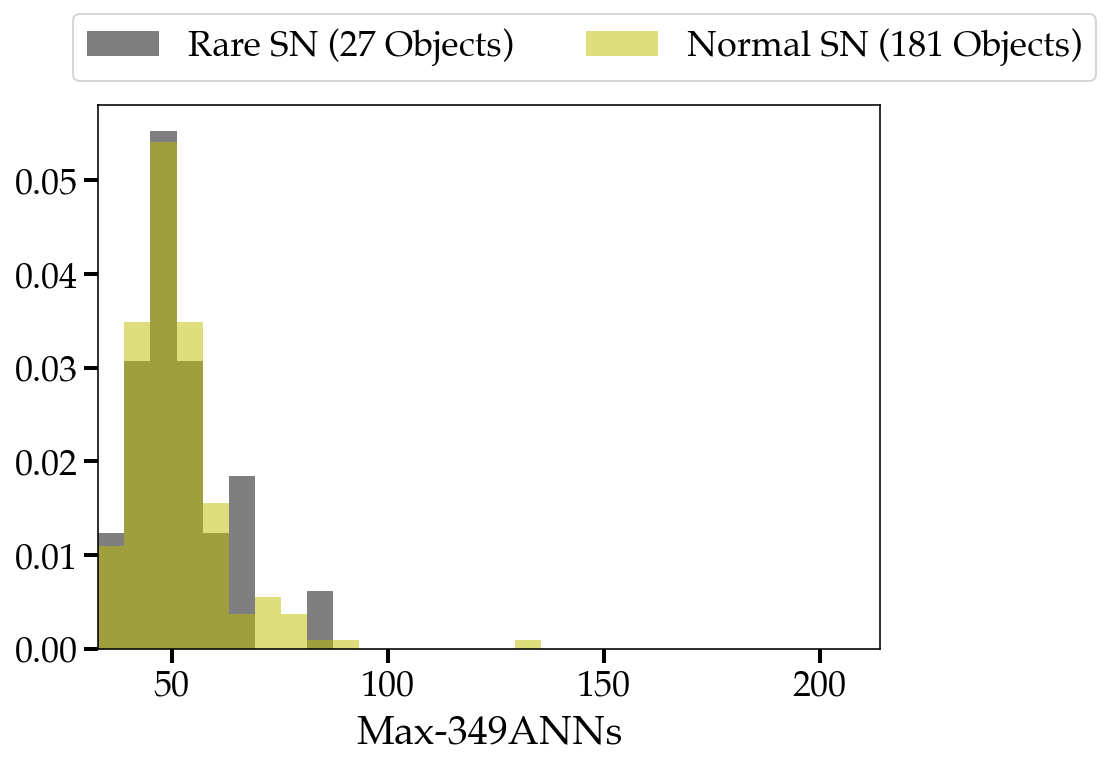

In [7]:
fig, ax = plt.subplots()
bins=np.linspace(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]), 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
#plt.xscale('log')
plt.xlabel(dist_col)
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig(f'../figures/histograms/ann_dist_all_df_{suffix}_2cls_{dist_col}.png')
plt.show()

In [8]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test

# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df[dist_col], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df[dist_col], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.2222222222222222
P-value: 0.6826506952495771
The two distributions are likely the same.


In [9]:
np.median(normal_sn_df[dist_col])

48.86520004272461

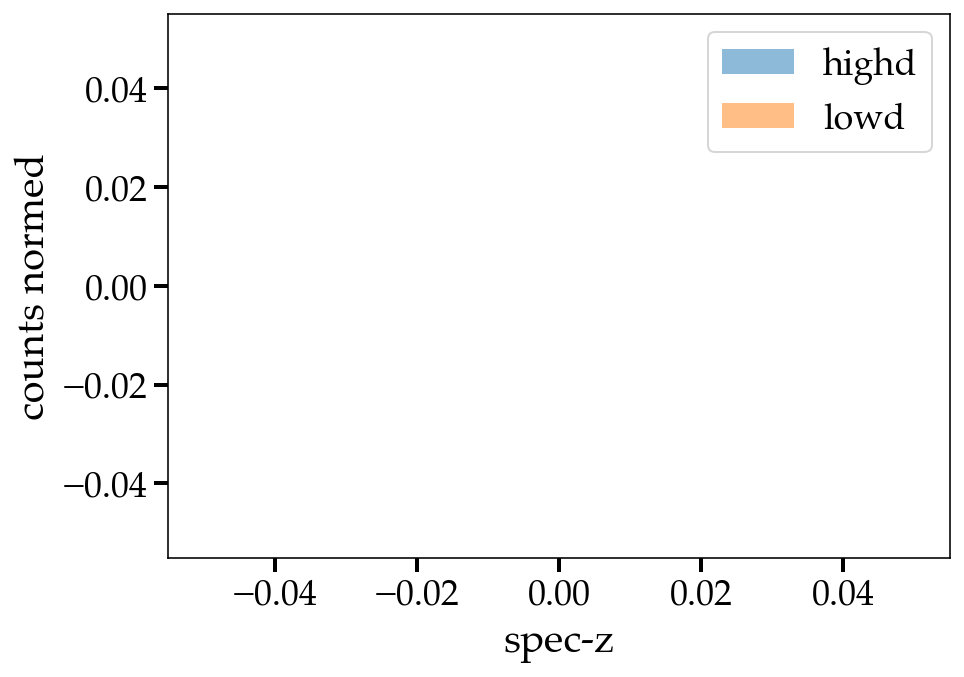

In [10]:
normal_sn_df = normal_sn_df[normal_sn_df.spec_z >= 0]

normal_sn_highd_df = normal_sn_df[normal_sn_df[dist_col] >= np.median(normal_sn_df[dist_col])+100]
normal_sn_lowd_df = normal_sn_df[normal_sn_df[dist_col] <= np.median(normal_sn_df[dist_col])+100]

bins=np.linspace(np.min(normal_sn_highd_df.spec_z), np.max(normal_sn_highd_df.spec_z), 31)
plt.hist(normal_sn_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(normal_sn_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [11]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_lowd_df.spec_z, size=len(normal_sn_highd_df), replace=False)
    stat, p_value = ks_2samp(normal_sn_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

ValueError: Data passed to ks_2samp must not be empty

In [ ]:
np.median(rare_sn_df[dist_col])

In [ ]:
rare_sn_df = rare_sn_df[rare_sn_df.spec_z >= 0]

rare_sn_highd_df = rare_sn_df[rare_sn_df[dist_col] >= np.median(rare_sn_df[dist_col])+100]
rare_sn_lowd_df = rare_sn_df[rare_sn_df[dist_col] <= np.median(rare_sn_df[dist_col])+100]

bins=np.linspace(np.min(rare_sn_highd_df.spec_z), np.max(rare_sn_highd_df.spec_z), 31)
plt.hist(rare_sn_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(rare_sn_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [ ]:
len(rare_sn_lowd_df)

In [ ]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(rare_sn_lowd_df.spec_z, size=len(rare_sn_highd_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

fig, ax = plt.subplots()
bins=np.linspace(25, 150, 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df["Mean-49ANNs"], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df["Mean-49ANNs"], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(25, 150)
plt.xlabel('Mean-49ANNs')
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig('../figures/histograms/ann_dist_all_df_hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_2cls_Mean.png')
plt.show()

from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df["Mean-49ANNs"], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df["Mean-49ANNs"], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

## No statistical difference between Rare SN and Normal SN 

In [ ]:
fig, ax = plt.subplots()
bins=np.linspace(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]), 31)
    

rare_snIa_l = ['SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM', 'SN Ia-pec', 'SN Iax[02cx-like]']
rare_snIa_df = merge_df[merge_df.tns_cls.isin(rare_snIa_l)]
ax.hist(rare_snIa_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN Ia ({len(rare_snIa_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_snIa_l = ['SN Ia']
normal_snIa_df = merge_df[merge_df.tns_cls.isin(normal_snIa_l)]
ax.hist(normal_snIa_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN Ia ({len(normal_snIa_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
plt.xlabel(dist_col)
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig(f'../figures/histograms/ann_dist_all_df_{suffix}_2cls_{dist_col}_Ia.png')
plt.show()

In [ ]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_snIa_subsample = np.random.choice(normal_snIa_df[dist_col], size=len(rare_snIa_df), replace=False)
    stat, p_value = ks_2samp(rare_snIa_df[dist_col], normal_snIa_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

## No statistical difference between Rare SN Ia and Normal SN Ia...

In [ ]:
np.median(normal_snIa_df[dist_col])

In [ ]:
normal_snIa_highd_df = normal_snIa_df[normal_snIa_df[dist_col] >= np.median(normal_snIa_df[dist_col])+100]
normal_snIa_lowd_df = normal_snIa_df[normal_snIa_df[dist_col] <= np.median(normal_snIa_df[dist_col])+100]

In [ ]:
normal_snIa_highd_df = normal_snIa_highd_df[normal_snIa_highd_df.spec_z >= 0]

bins=np.linspace(np.min(normal_snIa_highd_df.spec_z), np.max(normal_snIa_highd_df.spec_z), 31)
plt.hist(normal_snIa_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(normal_snIa_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [ ]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_snIa_lowd_df.spec_z, size=len(normal_snIa_highd_df), replace=False)
    stat, p_value = ks_2samp(normal_snIa_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

In [ ]:
np.median(rare_snIa_df[dist_col])

In [ ]:
rare_snIa_df = rare_snIa_df[rare_snIa_df.spec_z>=0]

rare_snIa_highd_df = rare_snIa_df[rare_snIa_df[dist_col] >= np.median(rare_snIa_df[dist_col])+100]
rare_snIa_lowd_df = rare_snIa_df[rare_snIa_df[dist_col] <= np.median(rare_snIa_df[dist_col])+100]

bins=np.linspace(np.min(rare_snIa_df.spec_z), np.max(rare_snIa_df.spec_z), 31)

plt.hist(rare_snIa_highd_df.spec_z, bins=bins, alpha=0.5, density=True, label='highd')
plt.hist(rare_snIa_lowd_df.spec_z, bins=bins, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [ ]:
len(rare_snIa_highd_df)

In [ ]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(rare_snIa_lowd_df.spec_z, size=len(rare_snIa_highd_df), replace=False)
    stat, p_value = ks_2samp(rare_snIa_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

# Objs w/ high distances ANNs are Bright/closeby (generally...)
# TODO: how to define "rare"? --> Closeby & bright or rare phenomenology or ???
# Maybe "normalize out" brightness to focus on truly rare SN classes/types/ LCs?

# UPDATED: brightness CAN be normalized out (w/ l1 norm and MI_classif), but tradeoff between good similarity (and host galaxy). If host gal weights all = 0.008 (1/120), then sim is good but high d and low d correspond to low z and high z, respectively. However, if I don't overweight hosts, sim search is not as good but high d and low d DO NOT correspond to low z and high z. So high d and low d objects are not dependent on redshift! But still no diff between rare SN and normal SN ... :( ?

# L1 norm & MI_classif (+changes) normalizes brightness ANN d but not great at AD, but Standard Scaler & MI_classif (+changes) is good at Sim Search, but not great at AD. What is great at AD if features overlap??? Try other scalers?

## TODO: find a new method for really Rare SN!
## TODO: Also, find if Rare SN--> Rare SN and Normal SN --> Normal SN

In [4]:
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after"
#suffix="hasTNS-spec_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"
#suffix="hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"

full_ann_properties_df = pd.read_csv(f'../dataframes/full_ann101_properties_df_{suffix}.csv', index_col=0)
full_ann_properties_df

,ann=0_ztfid,ann=1_ztfid,ann=2_ztfid,ann=3_ztfid,ann=4_ztfid,ann=5_ztfid,ann=6_ztfid,ann=7_ztfid,ann=8_ztfid,ann=9_ztfid,...,ann=91_spec_z,ann=92_spec_z,ann=93_spec_z,ann=94_spec_z,ann=95_spec_z,ann=96_spec_z,ann=97_spec_z,ann=98_spec_z,ann=99_spec_z,ann=100_spec_z
ZTF21abdauiq,ZTF21abdauiq,ZTF21abwtyle,ZTF21acimaio,ZTF20acmntog,ZTF21abizxrv,ZTF18abuahio,ZTF21aaxxetp,ZTF19aavoqbe,ZTF21aaxtufg,ZTF21aacsnql,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
ZTF21aaplfah,ZTF21aaplfah,ZTFabc09080,ZTF20acukxat,ZTFabc58529,ZTF21abmdhes,ZTFabc73130,ZTFabc54979,ZTFabc78612,ZTFabc30801,ZTF20acquetr,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
ZTF21aapomdb,ZTF21aapomdb,ZTFabc07155,ZTFabc26829,ZTFabc04707,ZTF21aasbjgq,ZTFabc46930,ZTF20achtxbi,ZTFabc62495,ZTFabc44432,ZTFabc52328,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
ZTF20acpayvy,ZTF20acpayvy,ZTFabc60940,ZTFabc39853,ZTFabc33490,ZTFabc94444,ZTFabc93050,ZTFabc24020,ZTFabc13397,ZTF21abvgprv,ZTFabc09273,...,0.099,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
ZTF20acnvmbp,ZTF20acnvmbp,ZTF20acmwfal,ZTF21abvgprv,ZTF20acmloum,ZTFabc48952,ZTFabc71907,ZTFabc69817,ZTFabc01989,ZTFabc84746,ZTFabc66583,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaxsowb,ZTF21aaxsowb,ZTF21aaphzlq,ZTF21aarmlkr,ZTF21abcptwm,ZTF21aavouex,ZTF21abcjbbp,ZTF21aagocxm,ZTF21abifsyr,ZTF21acerczf,ZTF21abwtyle,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
ZTF21aapkuur,ZTF21aapkuur,ZTF20aciuftf,ZTF21aagmrym,ZTFabc57635,ZTF20acmxgdv,ZTF18abnzney,ZTF20acxbadv,ZTF21aafdwls,ZTF20acmocrp,ZTF20acpyndh,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
ZTF21aaxhveb,ZTF21aaxhveb,ZTFabc92088,ZTF21aasrcgd,ZTF21abfyqtx,ZTF21aaqvtcn,ZTFabc42506,ZTF20acplqek,ZTFabc26322,ZTFabc70841,ZTF20adafguh,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
ZTF21abcmmdl,ZTF21abcmmdl,ZTFabc07112,ZTF19aaadwlg,ZTFabc41913,ZTFabc43536,ZTF21ablwcnz,ZTFabc15415,ZTF21aaafgmv,ZTF21aagojoi,ZTFabc69673,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0


In [5]:
full_ann_tns_cls_df = full_ann_properties_df.iloc[:, 303:404]
full_ann_tns_cls_df

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF21abdauiq,None,None,None,SN Ia,None,None,None,None,None,None,...,None,None,SN IIn,SN IIn,SN IIn,None,None,None,SN IIn,None
ZTF21aaplfah,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like
ZTF21aapomdb,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec
ZTF20acpayvy,None,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia,...,SN Ia,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN Ia,SLSN-II,SLSN-II,SLSN-II,SLSN-II
ZTF20acnvmbp,None,None,None,None,SN Ia,SN Ia,SN Ic-BL,SN Ic-BL,SN Ic-BL,SN Ic-BL,...,SN Ic-BL,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ic-BL,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaxsowb,None,None,None,None,None,None,None,None,None,None,...,None,None,SN Ia,None,SN Ib,SN Ib,None,SN II,SN Ib,SN Ib
ZTF21aapkuur,SN Ia,SN Ia,None,SN Ia,None,None,None,None,None,None,...,SN IIn,SN IIn,SN IIn,None,SN IIn,SN II,SN Ia,SN Ia,SN IIn,SN Ia
ZTF21aaxhveb,None,SN Ia,None,None,None,SN Ia,SN Ia,SN Ia,SN Ia,None,...,SN I,None,SN I,SN I,SN I,SN I,SN I,SN I,SN I,None
ZTF21abcmmdl,None,SN Ia,None,SN II,SN Ia,None,SN II,SN Ia,None,SN II,...,SN IIP,None,SN IIP,SN I,SN I,SN I,SN I,SN I,SN I,SN I


In [6]:
full_ann_spec_z_df = full_ann_properties_df.iloc[:, 404:505]
full_ann_spec_z_df

,ann=0_spec_z,ann=1_spec_z,ann=2_spec_z,ann=3_spec_z,ann=4_spec_z,ann=5_spec_z,ann=6_spec_z,ann=7_spec_z,ann=8_spec_z,ann=9_spec_z,...,ann=91_spec_z,ann=92_spec_z,ann=93_spec_z,ann=94_spec_z,ann=95_spec_z,ann=96_spec_z,ann=97_spec_z,ann=98_spec_z,ann=99_spec_z,ann=100_spec_z
ZTF21abdauiq,-99.0000,-99.00,-99.000000,0.09,-99.00,-99.0,-99.000,-99.000,-99.0,-99.000000,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
ZTF21aaplfah,0.0358,-99.00,0.042546,-99.00,0.04,-99.0,-99.000,-99.000,-99.0,0.030791,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
ZTF21aapomdb,0.0700,-99.00,-99.000000,-99.00,0.08,-99.0,0.070,-99.000,-99.0,-99.000000,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
ZTF20acpayvy,-99.0000,-99.00,-99.000000,-99.00,-99.00,-99.0,-99.000,-99.000,-99.0,-99.000000,...,0.099,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
ZTF20acnvmbp,-99.0000,-99.00,-99.000000,-99.00,-99.00,-99.0,-99.000,-99.000,-99.0,-99.000000,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaxsowb,-99.0000,-99.00,-99.000000,-99.00,-99.00,-99.0,-99.000,-99.000,-99.0,-99.000000,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
ZTF21aapkuur,0.1000,0.13,-99.000000,-99.00,-99.00,-99.0,-99.000,-99.000,-99.0,-99.000000,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
ZTF21aaxhveb,-99.0000,-99.00,-99.000000,-99.00,-99.00,-99.0,0.083,-99.000,-99.0,-99.000000,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
ZTF21abcmmdl,-99.0000,-99.00,-99.000000,-99.00,-99.00,-99.0,-99.000,0.079,-99.0,-99.000000,...,-99.000,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0


In [7]:
# Create Graph df
graph_df = pd.DataFrame()
graph_df['node'] = full_ann_tns_cls_df["ann=0_tns_cls"]

ann_tns_cls_col_list= [f'ann={col}_tns_cls' for col in range(1, 101)]
graph_df['neighbors'] = full_ann_tns_cls_df[ann_tns_cls_col_list].apply(list, axis=1)
graph_df

,node,neighbors
ZTF21abdauiq,None,"[None, None, SN Ia, None, None, None, None, No..."
ZTF21aaplfah,SN Ia,"[SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN ..."
ZTF21aapomdb,SN Ia,"[SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN ..."
ZTF20acpayvy,None,"[SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN ..."
ZTF20acnvmbp,None,"[None, None, None, SN Ia, SN Ia, SN Ic-BL, SN ..."
...,...,...
ZTF21aaxsowb,None,"[None, None, None, None, None, None, None, Non..."
ZTF21aapkuur,SN Ia,"[SN Ia, None, SN Ia, None, None, None, None, N..."
ZTF21aaxhveb,None,"[SN Ia, None, None, None, SN Ia, SN Ia, SN Ia,..."
ZTF21abcmmdl,None,"[SN Ia, None, SN II, SN Ia, None, SN II, SN Ia..."


In [8]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ia-91T-like']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF21aarycyl,SN Ia-91T-like,None,None,None,None,None,None,None,None,None,...,SN IIb,None,None,None,None,SN IIb,SN II,SN IIb,SN Ia,SN Ia
ZTF21aanrvcq,SN Ia-91T-like,SN II,SN II,SN Ia,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,...,SN Ia-91T-like,SN Ic,SN Ic,SN Ic,SN Ia-91T-like,SN II,SN Ia-91T-like,SN Ic,SN Ic,SN Ic
ZTF20acjdhof,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,...,SN Ia-91T-like,SN Ia-91T-like,SN Ia,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,None,SN Ia-91T-like


In [9]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ia']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF21aaplfah,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like
ZTF21aapomdb,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec
ZTF21aahfjlo,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia-pec,SN Ia-pec,SN Ia-pec,...,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia,SN Ia-pec,SN Ia-pec
ZTF21abcmepi,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia,SN Ia,None,SN Ia,SN Ia,...,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I
ZTF20acobamg,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,None,None,SLSN-I,SLSN-I,SLSN-I,...,SN IIn,SLSN-I,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SLSN-I,SLSN-I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20accodxy,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia,SN Ia,...,SN Ia,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN Ia,SLSN-II
ZTF21abcnkbe,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SN Ia,SLSN-I,SLSN-I
ZTF21absbwyz,SN Ia,SN Ia,None,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia,SN Ia,...,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN Ia,SN Ia,SLSN-II,SN Ia,SN Ia
ZTF21aasafkl,SN Ia,SN Ia,SN I,SN I,SN I,SN I,SN I,SN I,SN I,SN I,...,SN I,SN I,SN Ia,SN I,SN I,SN I,SN I,SN I,SN I,SN I


In [10]:
full_ann_properties_df.columns.to_list()

['ann=0_ztfid',
 'ann=1_ztfid',
 'ann=2_ztfid',
 'ann=3_ztfid',
 'ann=4_ztfid',
 'ann=5_ztfid',
 'ann=6_ztfid',
 'ann=7_ztfid',
 'ann=8_ztfid',
 'ann=9_ztfid',
 'ann=10_ztfid',
 'ann=11_ztfid',
 'ann=12_ztfid',
 'ann=13_ztfid',
 'ann=14_ztfid',
 'ann=15_ztfid',
 'ann=16_ztfid',
 'ann=17_ztfid',
 'ann=18_ztfid',
 'ann=19_ztfid',
 'ann=20_ztfid',
 'ann=21_ztfid',
 'ann=22_ztfid',
 'ann=23_ztfid',
 'ann=24_ztfid',
 'ann=25_ztfid',
 'ann=26_ztfid',
 'ann=27_ztfid',
 'ann=28_ztfid',
 'ann=29_ztfid',
 'ann=30_ztfid',
 'ann=31_ztfid',
 'ann=32_ztfid',
 'ann=33_ztfid',
 'ann=34_ztfid',
 'ann=35_ztfid',
 'ann=36_ztfid',
 'ann=37_ztfid',
 'ann=38_ztfid',
 'ann=39_ztfid',
 'ann=40_ztfid',
 'ann=41_ztfid',
 'ann=42_ztfid',
 'ann=43_ztfid',
 'ann=44_ztfid',
 'ann=45_ztfid',
 'ann=46_ztfid',
 'ann=47_ztfid',
 'ann=48_ztfid',
 'ann=49_ztfid',
 'ann=50_ztfid',
 'ann=51_ztfid',
 'ann=52_ztfid',
 'ann=53_ztfid',
 'ann=54_ztfid',
 'ann=55_ztfid',
 'ann=56_ztfid',
 'ann=57_ztfid',
 'ann=58_ztfid',
 'ann=5

In [11]:
full_ann_properties_df.loc['ZTF21aanrvcq']

ann=0_ztfid       ZTF21aanrvcq
ann=1_ztfid        ZTFabc89047
ann=2_ztfid        ZTFabc09620
ann=3_ztfid        ZTFabc56292
ann=4_ztfid        ZTFabc36246
                      ...     
ann=96_spec_z            -99.0
ann=97_spec_z            -99.0
ann=98_spec_z            -99.0
ann=99_spec_z            -99.0
ann=100_spec_z           -99.0
Name: ZTF21aanrvcq, Length: 505, dtype: object

In [12]:
Counter(graph_df['node'])

Counter({'None': 512,
         'SN Ia': 155,
         'SN II': 25,
         'SN Ic-BL': 2,
         'SN IIn': 10,
         'SN Ic': 3,
         'SN I': 2,
         'TDE': 2,
         'SN IIb': 1,
         'SLSN-II': 1,
         'SLSN-I': 1,
         'SN Ia-91T-like': 3,
         'SN Ib': 2,
         'SN Ia-91bg-like': 1,
         'SN IIP': 1,
         'SN Ia-pec': 1})

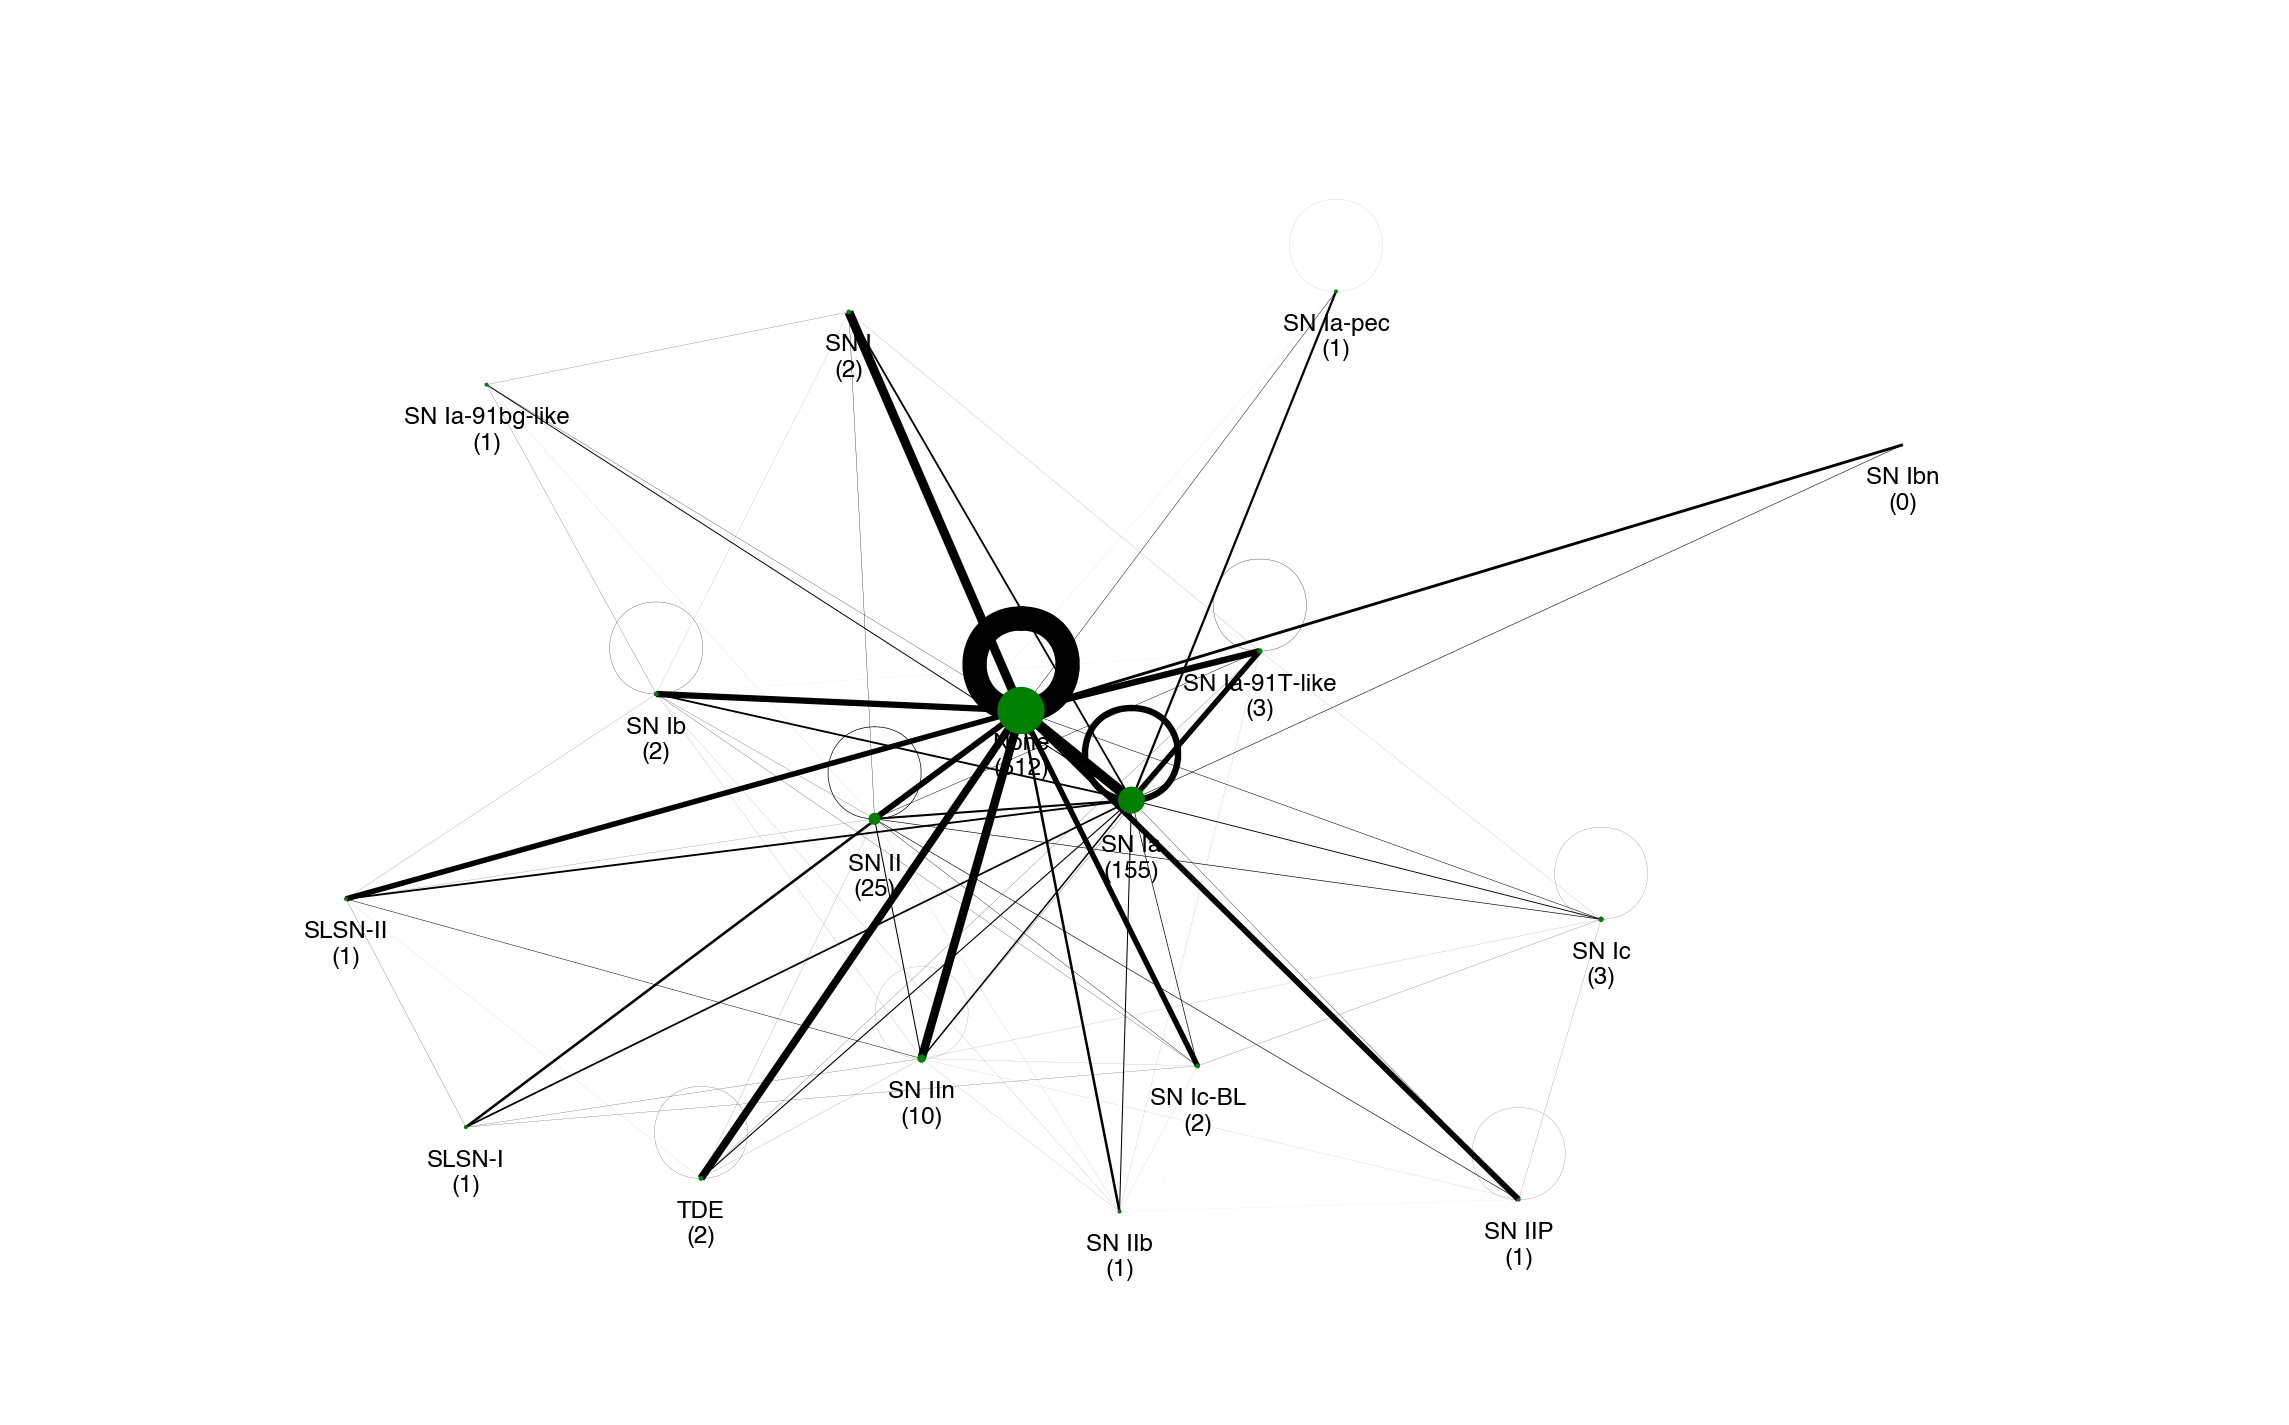

In [23]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Create a sample dataframe with node and edge data
df = graph_df.copy()
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.Graph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]

node_count = dict(Counter(graph_df['node']))

# Scale the node sizes by the occurrences of the node
#node_sizes = [1.2 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]

# for 80-20
node_count.update({'SN Ibn': 0})
node_sizes = [node_count[node] * 1 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(16, 10))
nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] - 0.07)
    
# # count the number of times of each node 
# node_count = dict(Counter(df['node']))

# scale node sizes by frequency
#node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
node_labels_d1 = {node: f"{node}\n({node_count[node]})" for node in G.nodes() if node!='SN Ia' and node!='SN II'}
node_labels_d2 = {node: f"\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN II'}
node_labels = {node: f"\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN Ia'}


node_labels_d2.update(node_labels_d1)
node_labels.update(node_labels_d2)

nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()


folder_path = f"../figures/graphs/{suffix}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
plt.savefig(f'../figures/graphs/{suffix}/all_classes_network_size_scaled_ann101.jpg', dpi=300)
plt.show()


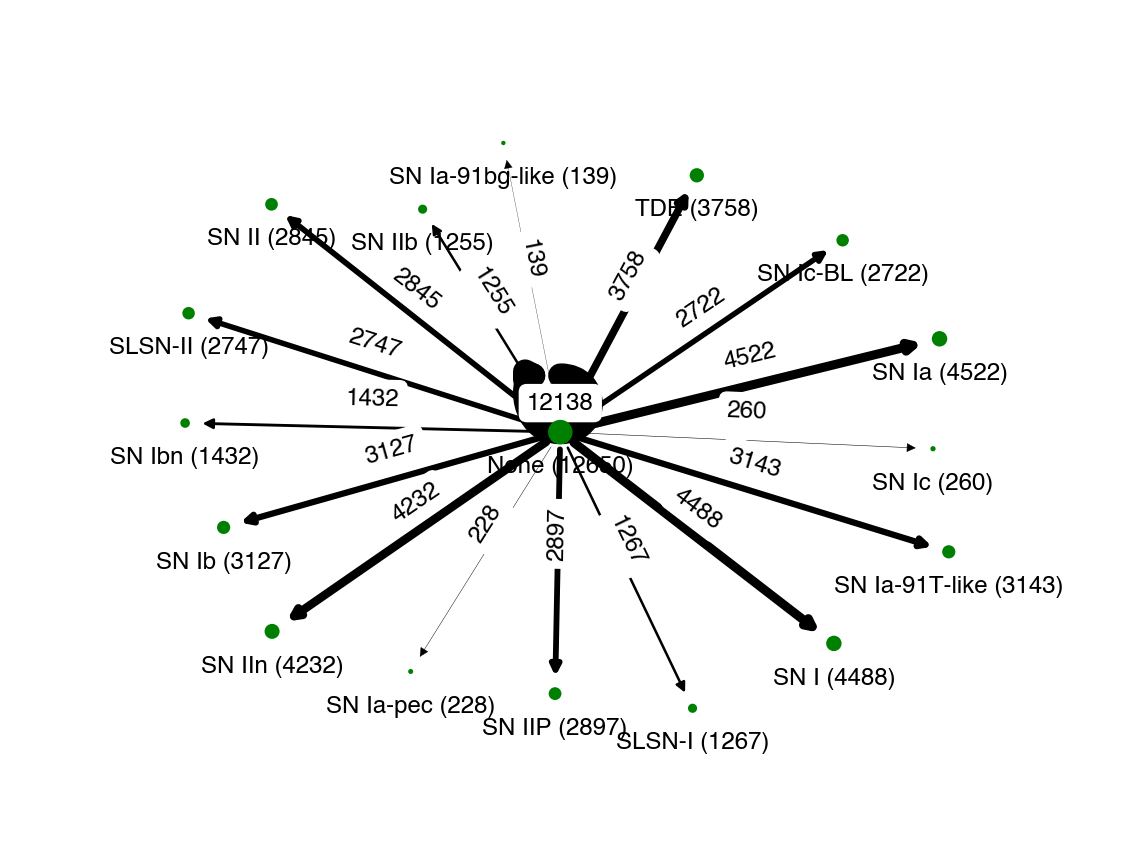

In [24]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

cls = 'None'
graph_df_cls = graph_df[graph_df.node == cls]


# Create a sample dataframe with node and edge data
df = graph_df_cls
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.DiGraph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]

# Scale the node sizes by the occurrences of the node
#node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
#print(node_sizes)

# explode the lists in the second column into separate rows
df = graph_df_cls
df_expl = df.explode('neighbors')

# group the data frame by the label column and count the number of unique values for each group
unique_node_d = dict(Counter(df['node']))
unique_neighbors_d = dict(Counter(df_expl['neighbors']))

for key in unique_neighbors_d:
    if key in unique_node_d:
        unique_node_d[key] += unique_neighbors_d[key]
    else:
        unique_node_d[key] = unique_neighbors_d[key]
        
node_count = unique_node_d
node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] +.1)
    
    
# # count the number of times of each node 
# node_count = dict(Counter(graph_df_cv['node']))

# # scale node sizes by frequency
# node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}

nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')


plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()
#plt.savefig(f'../figures/graphs/{suffix}_size_scaled_None.jpg', dpi=300)
plt.show()


None


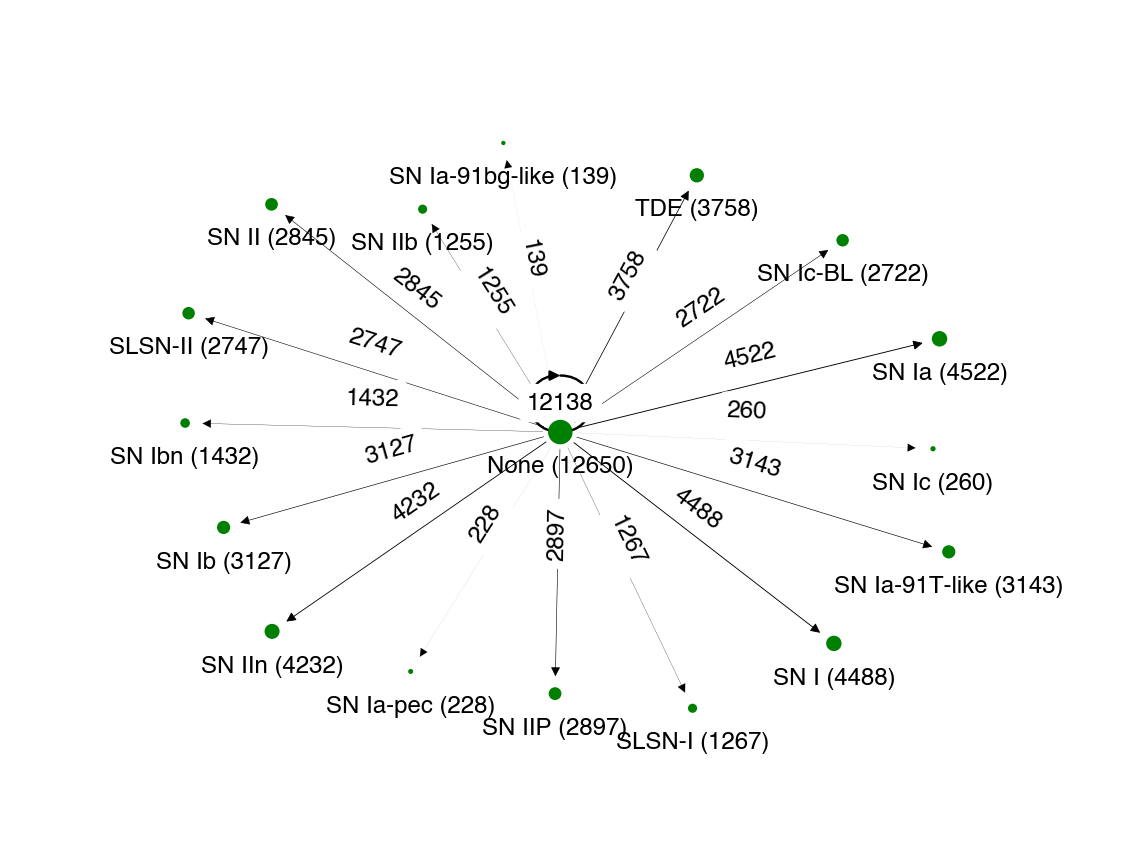

SLSN-I


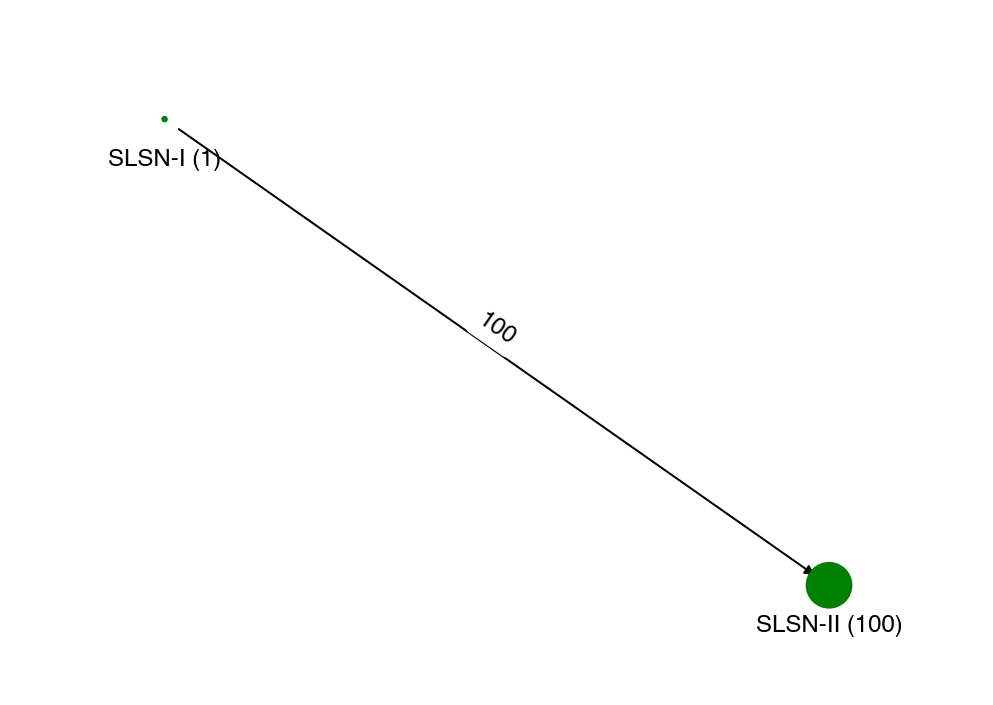

SLSN-II


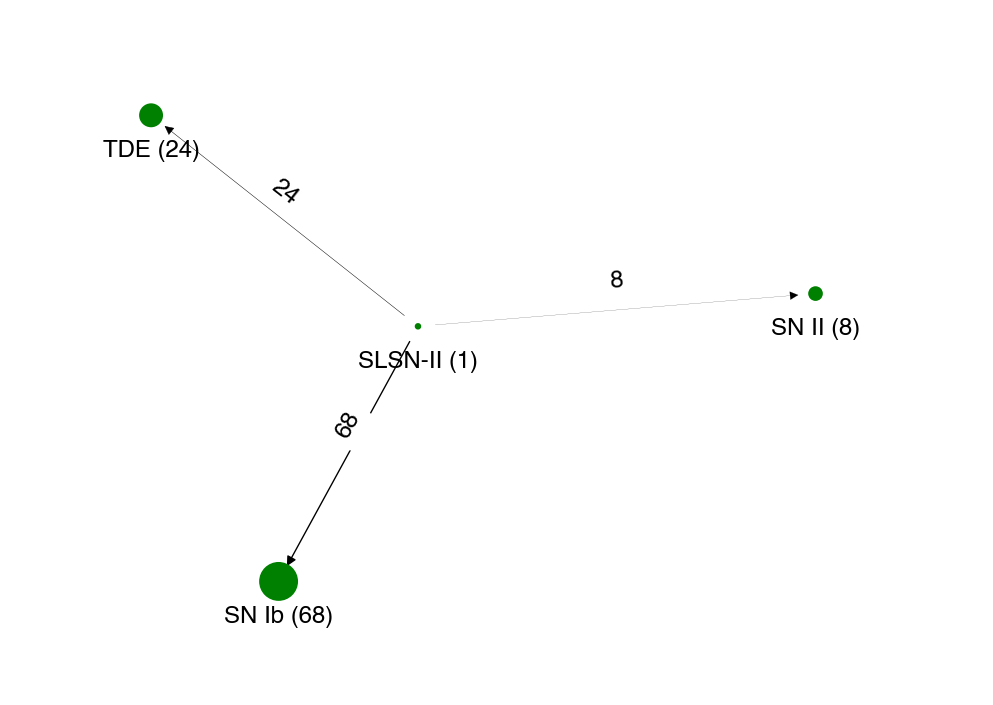

SN I


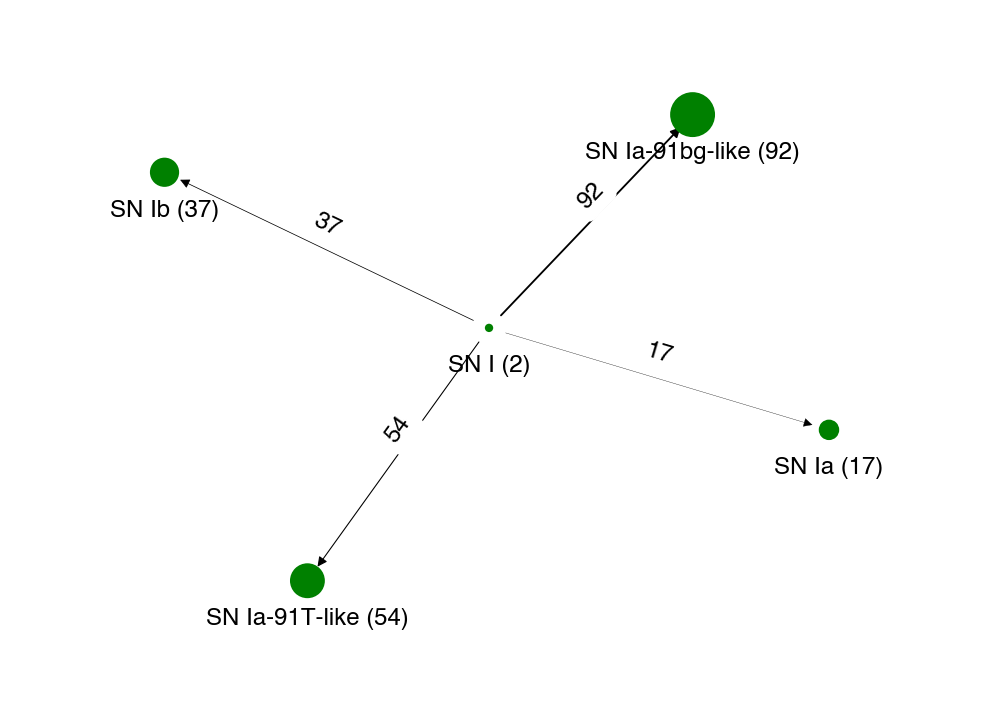

SN II


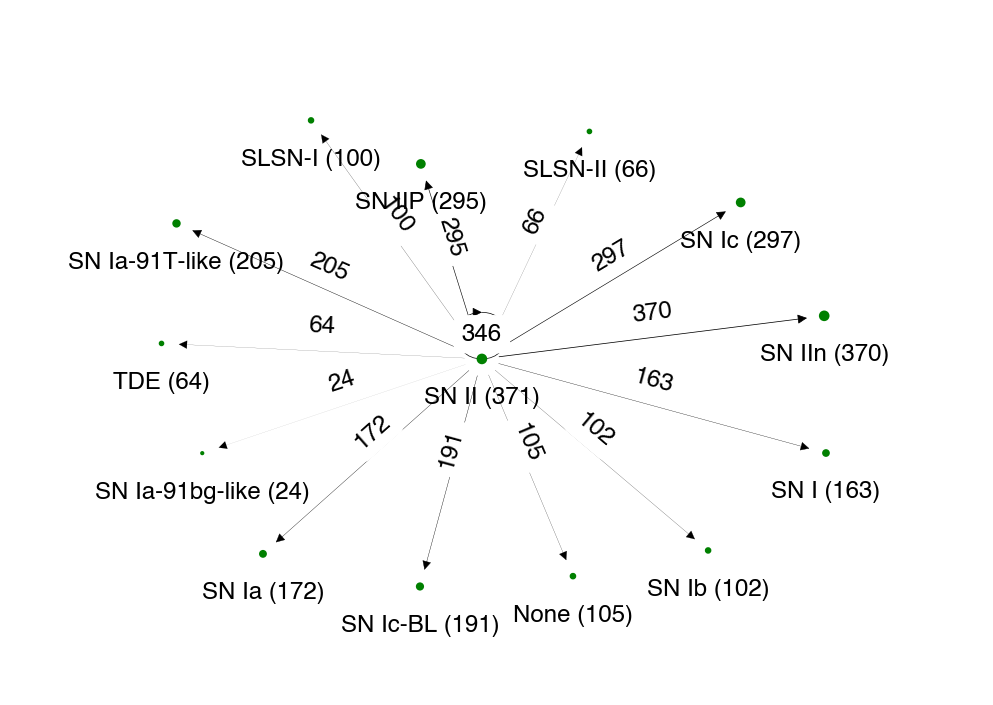

SN IIP


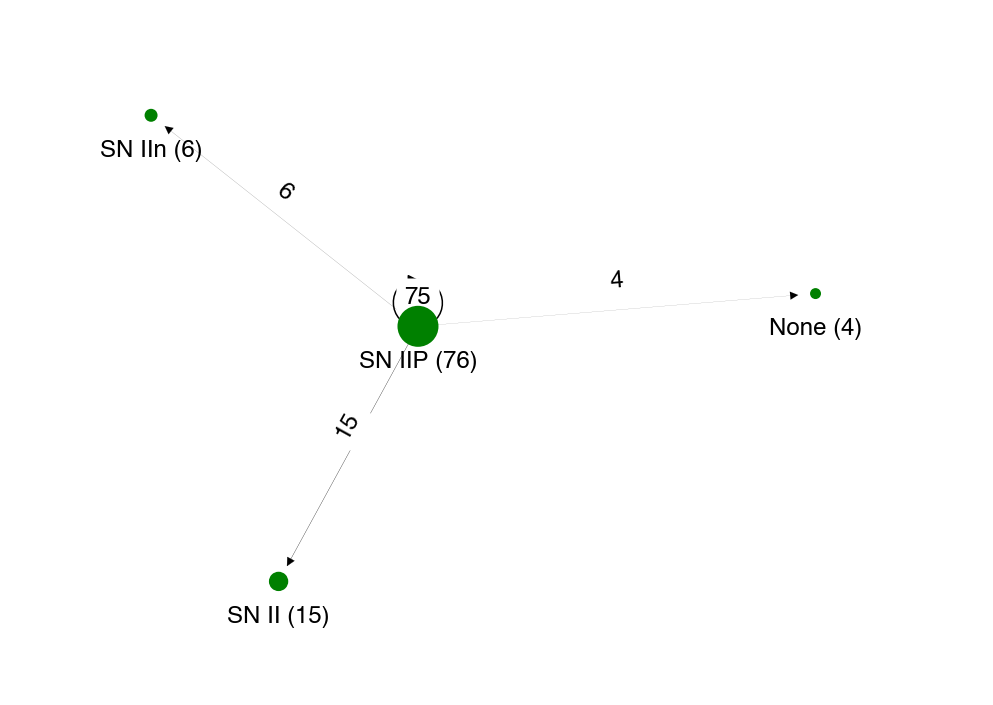

SN IIb


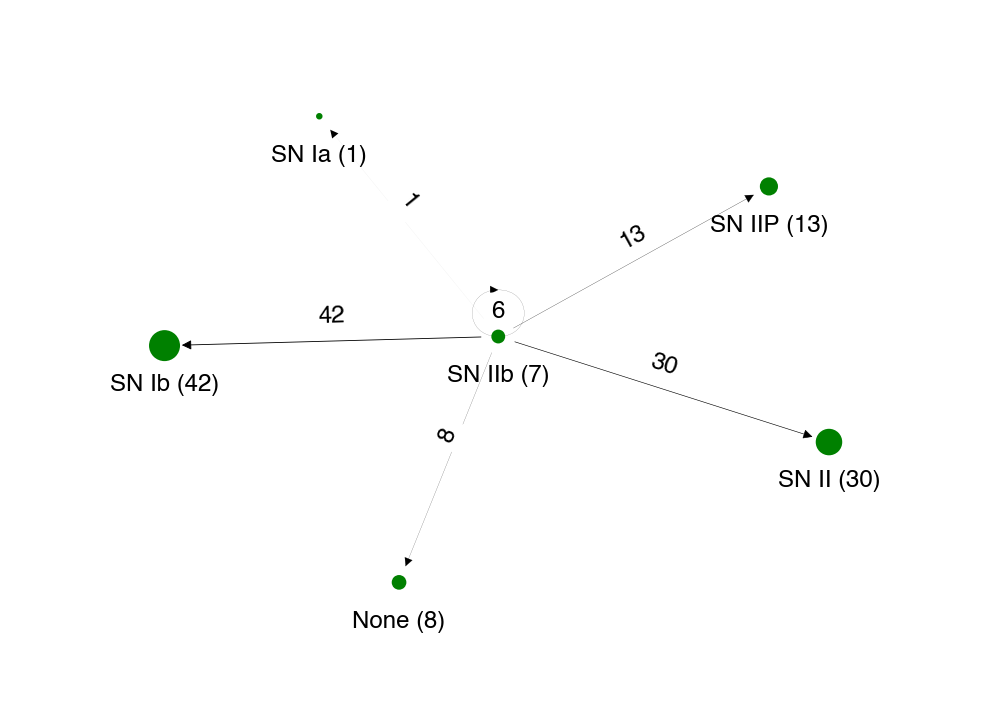

SN IIn


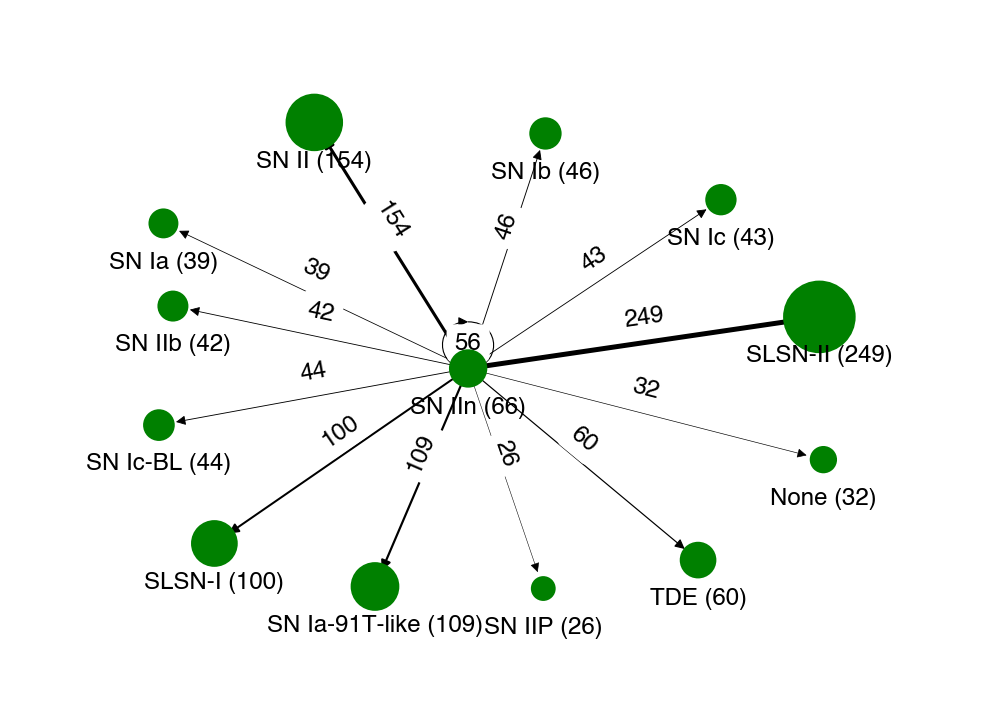

SN Ia


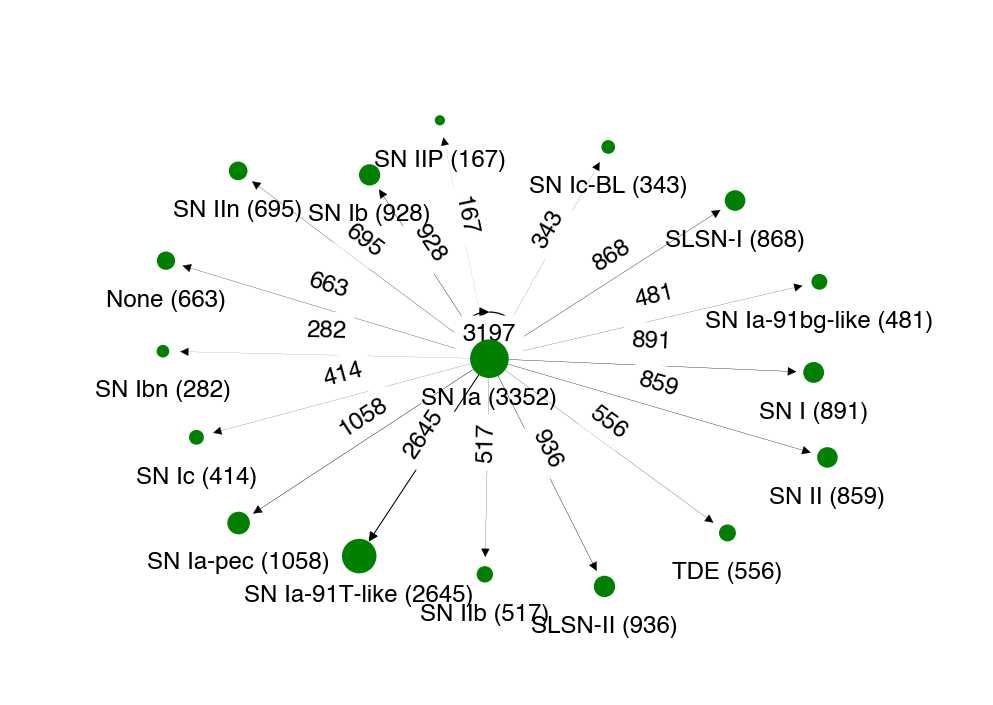

SN Ia-91T-like


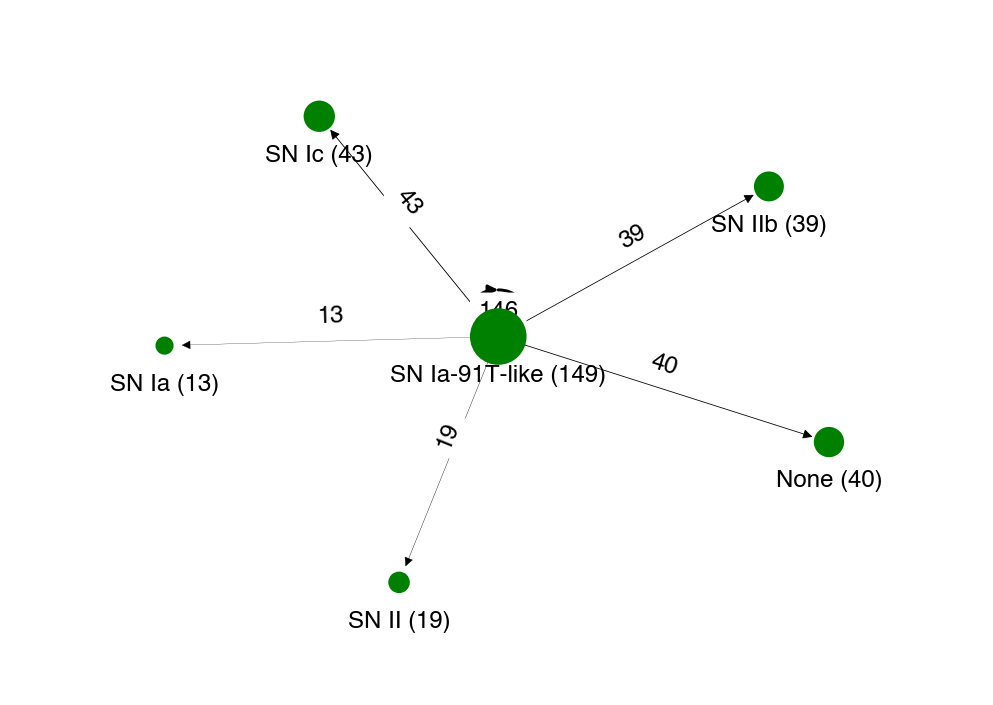

SN Ia-91bg-like


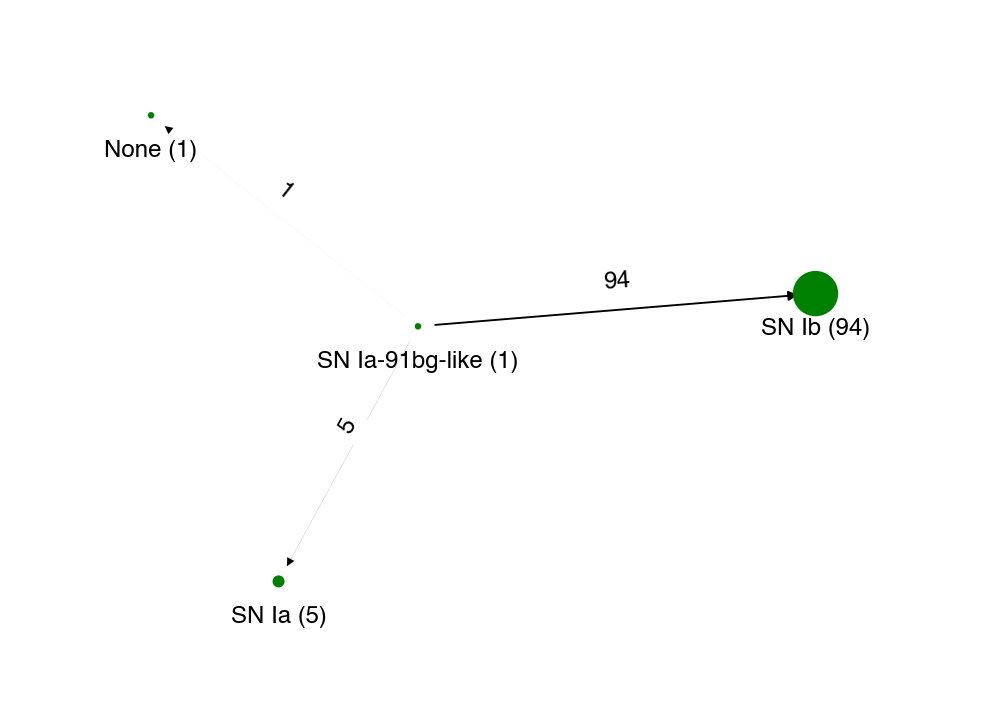

SN Ia-pec


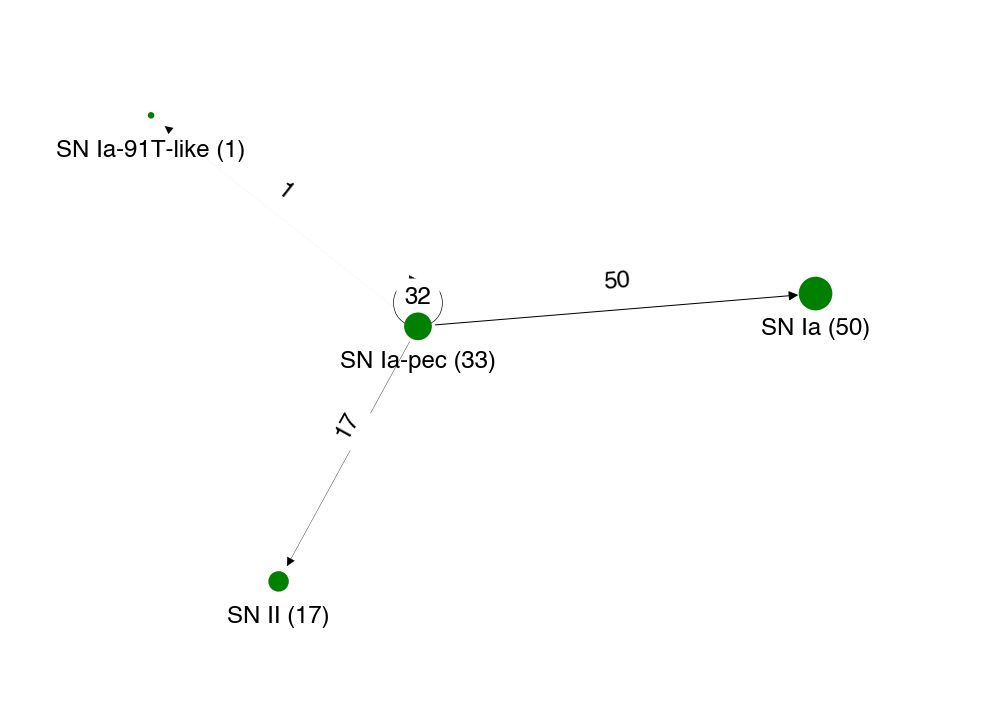

SN Ib


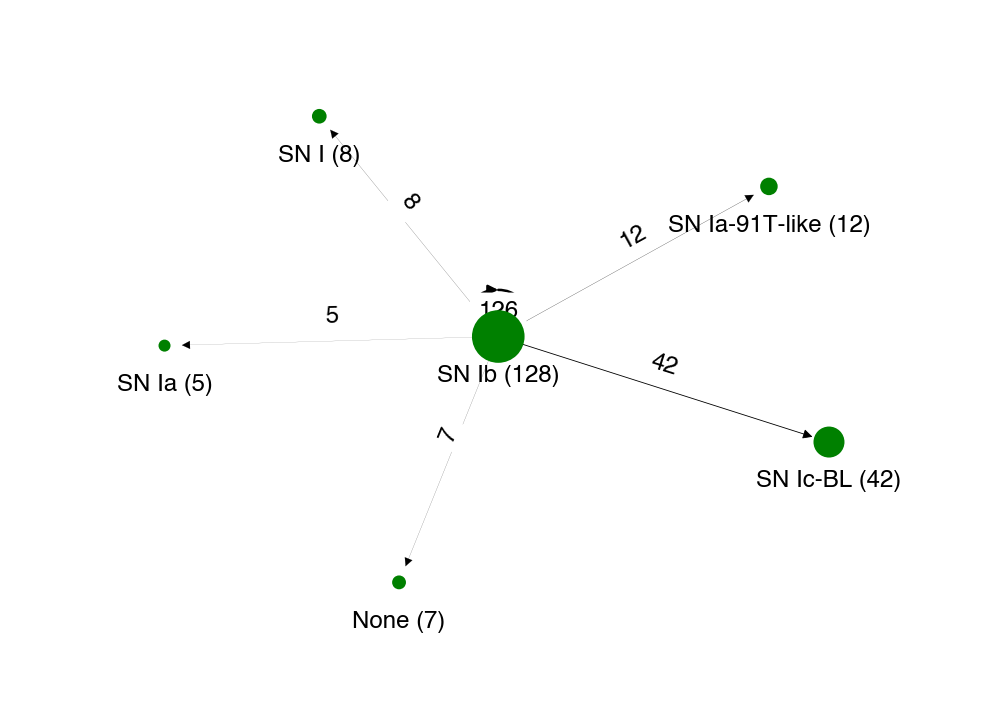

SN Ic


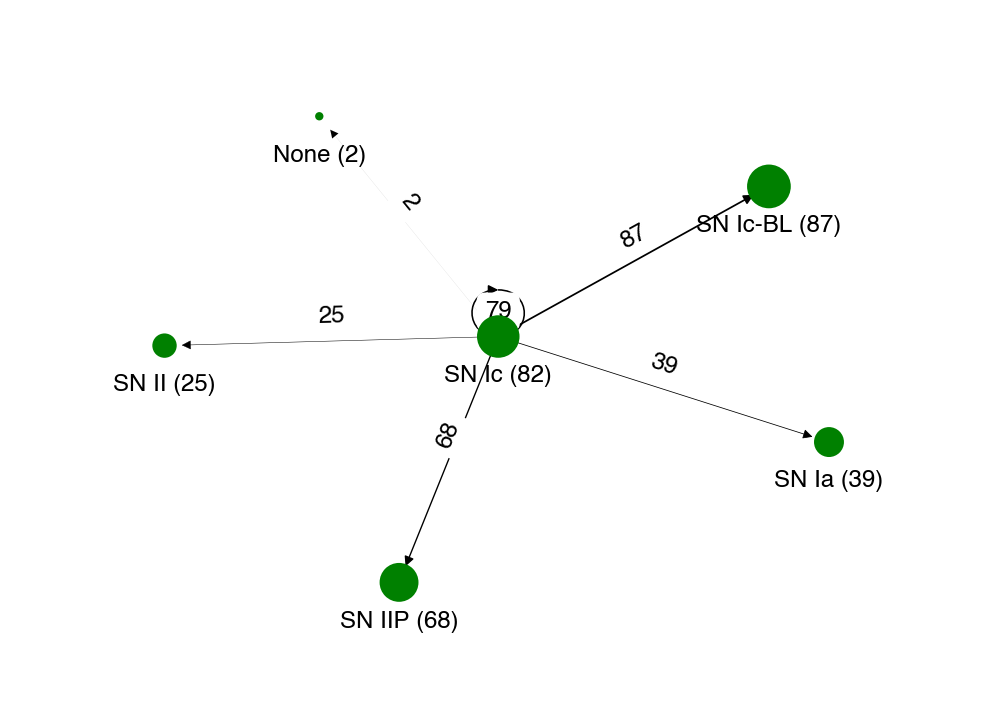

SN Ic-BL


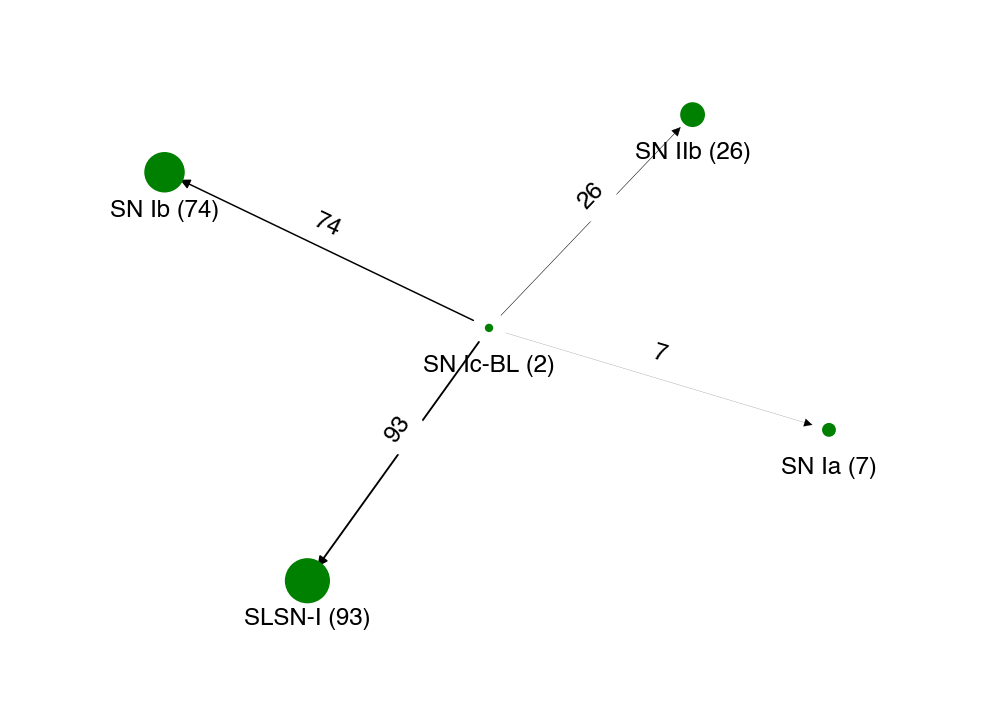

TDE


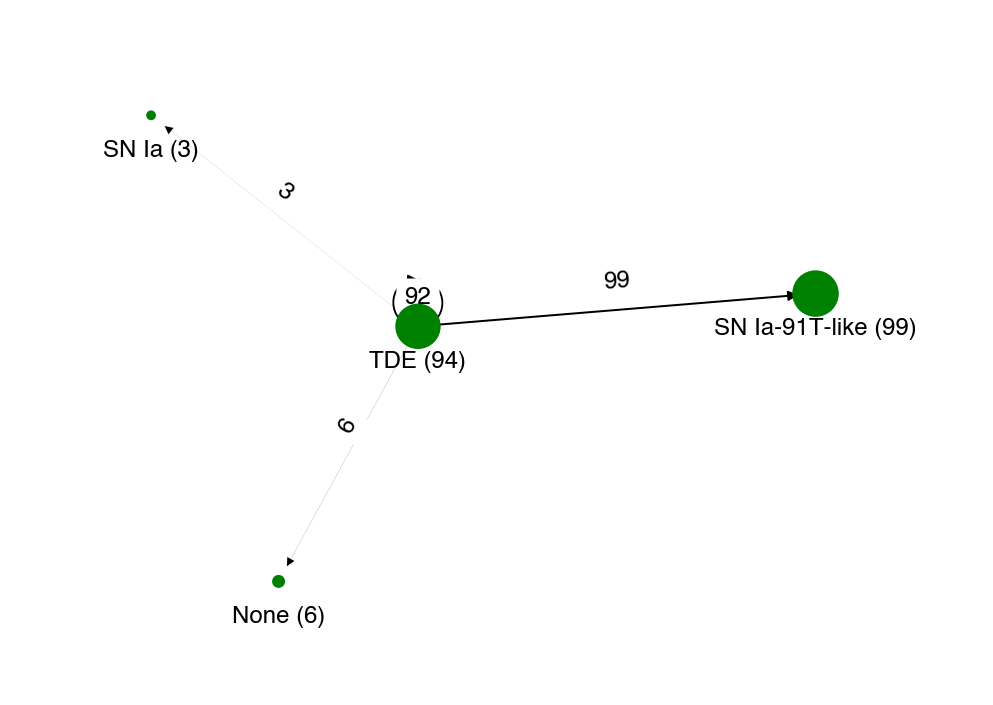

In [25]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

for cls in np.unique(graph_df['node']):
    print(cls)
    
    graph_df_cls = graph_df[graph_df.node == cls]


    # Create a sample dataframe with node and edge data
    df = graph_df_cls
    # Create a list of edges
    edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

    # Create a network graph from the edges
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # Compute the frequency of each unique connection
    edge_freq = {}
    for u, v in edges:
        key = (min(u, v), max(u, v))
        edge_freq[key] = edge_freq.get(key, 0) + 1

    # Add edge labels with frequency
    edge_labels = {}
    for u, v, d in G.edges(data=True):
        key = (min(u, v), max(u, v))
        #if edge_freq[key] >= 500:
        edge_labels[(u, v)] = str(edge_freq[key])

        # set edge widths based on frequency
        if cls == 'SN Ia': edge_widths = [int(edge_labels[edge])/5000 for edge in edge_labels]
        elif cls == 'SN II': edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]
        elif cls == 'None': edge_widths = [int(edge_labels[edge])/10000 for edge in edge_labels]
        else: edge_widths = [int(edge_labels[edge])/100 for edge in edge_labels]

        # Scale the node sizes by the occurrences of the node
        #node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
        #print(node_sizes)

        # explode the lists in the second column into separate rows
        df_expl = df.explode('neighbors')

        # group the data frame by the label column and count the number of unique values for each group
        unique_node_d = dict(Counter(df['node']))
        unique_neighbors_d = dict(Counter(df_expl['neighbors']))

        for key in unique_neighbors_d:
            if key in unique_node_d:
                unique_node_d[key] += unique_neighbors_d[key]
            else:
                unique_node_d[key] = unique_neighbors_d[key]

    node_count = unique_node_d
    
    if cls == 'SN Ia': node_sizes = [node_count[node] * 0.1 for node in G.nodes()]
    elif cls == 'SN II': node_sizes = [node_count[node] * 0.05 for node in G.nodes()]
    elif cls == 'None': node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
    else: node_sizes = [node_count[node] * 5 for node in G.nodes()]
    #print(node_sizes)

    # Plot the graph
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

    # Move the labels of the nodes down right below the node
    pos_labels = {}
    for key, value in pos.items():
        pos_labels[key] = (value[0], value[1] +.1)


    # # count the number of times of each node 
    # node_count = dict(Counter(graph_df_cv['node']))

    # # scale node sizes by frequency
    # node_sizes = [node_count[node] * 9 for node in G.nodes()]

    # create labels with node and count information
    node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}

    nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

    nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

    cls = cls.replace(' ', '').replace('/','')
#     plt.axis('off')
#     plt.savefig(f'../figures/graphs/{suffix}_size_scaled_{cls}.jpg', dpi=300)
#     plt.show()

    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.tight_layout()
    
    folder_path = f"../figures/graphs/{suffix}"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    plt.savefig(f'../figures/graphs/{suffix}/size_scaled_{cls}_ann101.jpg', dpi=300)
    plt.show()


In [26]:
Counter(full_ann_tns_cls_df['ann=0_tns_cls'])

Counter({'None': 512,
         'SN Ia': 155,
         'SN II': 25,
         'SN Ic-BL': 2,
         'SN IIn': 10,
         'SN Ic': 3,
         'SN I': 2,
         'TDE': 2,
         'SN IIb': 1,
         'SLSN-II': 1,
         'SLSN-I': 1,
         'SN Ia-91T-like': 3,
         'SN Ib': 2,
         'SN Ia-91bg-like': 1,
         'SN IIP': 1,
         'SN Ia-pec': 1})

In [27]:
none_df = full_ann_tns_cls_df[(full_ann_tns_cls_df['ann=0_tns_cls'] == 'None')] 
none_df_cls = none_df.loc[none_df.apply(lambda x: x.value_counts().idxmax() == 'SN IIP', axis=1)]
none_df_cls

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF20acufkdp,None,SN Ia,SN Ia,None,SN Ia,None,SN IIb,SN IIb,SN IIb,SN IIb,...,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIb,SN IIP,SN IIP
ZTF21acebndp,None,None,None,SN II,SN II,None,SN II,None,SN II,None,...,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP
ZTF18abyaxyu,None,None,None,SN II,SN IIP,SN IIP,SN IIP,SN Ia,SN II,SN IIP,...,SN IIP,SN IIP,SN IIP,SN IIP,SN II,SN II,SN II,SN II,None,SN II
ZTF20acuozua,None,None,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,...,SN Ic,SN Ic,SN Ic,SN IIP,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic,SN Ic
ZTF21aaaorvq,None,None,None,SN II,SN II,SN II,SN II,SN II,SN II,SN II,...,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP
ZTF21aaaovwg,None,SN II,SN II,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,...,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP
ZTF18abscghc,None,None,None,None,SN II,None,SN II,None,None,SN IIP,...,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP
ZTF21aaynorj,None,None,None,None,None,SN II,SN II,SN II,None,SN II,...,SN IIP,SN IIP,SN IIP,SN IIP,None,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP
ZTF18aasxqmn,None,None,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,...,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP,SN IIP
ZTF21aavqlbe,None,None,None,None,None,None,None,None,SN Ia,SN Ia,...,SN IIP,SN IIP,SN IIP,SN Ia,SN IIP,None,SN IIP,None,SN IIP,SN IIP


In [28]:
for sn, cl in zip(none_df_cls.index, none_df_cls['ann=0_tns_cls']):
    print(f'https://alerce.online/object/{sn}', cl)

https://alerce.online/object/ZTF20acufkdp None
https://alerce.online/object/ZTF21acebndp None
https://alerce.online/object/ZTF18abyaxyu None
https://alerce.online/object/ZTF20acuozua None
https://alerce.online/object/ZTF21aaaorvq None
https://alerce.online/object/ZTF21aaaovwg None
https://alerce.online/object/ZTF18abscghc None
https://alerce.online/object/ZTF21aaynorj None
https://alerce.online/object/ZTF18aasxqmn None
https://alerce.online/object/ZTF21aavqlbe None
https://alerce.online/object/ZTF20acyxrbd None
https://alerce.online/object/ZTF21aapkzug None
https://alerce.online/object/ZTF21aapegkr None
https://alerce.online/object/ZTF18acurklz None
https://alerce.online/object/ZTF20acgyfxp None
https://alerce.online/object/ZTF20acudrou None
https://alerce.online/object/ZTF21abwmjdd None
https://alerce.online/object/ZTF21aagrimf None
https://alerce.online/object/ZTF21aagpdzy None
https://alerce.online/object/ZTF21aawgzty None
https://alerce.online/object/ZTF21aarnlgc None
https://alerc

In [29]:
# Not many Nones matched to SLSN are likely SLSN...
# Missed SLSN https://alerce.online/object/ZTF21aalyubu 
# Missed SLSN https://alerce.online/object/ZTF21aazrgtw

# TODO: make plots where x axis is ann distance, and y axis is line graphs of different classes, marked by ANN num

import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named 'df'
ann_columns = ['{}'.format(i) for i in range(1, 101)]
distance_columns = ['ann={}_d'.format(ann) for ann in ann_columns]
class_columns = ['ann={}_tns_cls'.format(ann) for ann in ann_columns]
has_tns_columns = ['ann={}_has_tns'.format(ann) for ann in ann_columns]

df = full_ann_properties_df.iloc[0:19]

# Define a mapping from label values to colors
color_map = {'Yes_TNS': 'green', 'No_TNS': 'yellow', 'Fake': 'red'}

fig, axs = plt.subplots(nrows=len(df), ncols=1, figsize=(8, 20), sharex=True)

for i, index_label in enumerate(df.index):
    ax = axs[i]
    # Get the ANN distances and classes for this row
    distances = df.loc[index_label, distance_columns].values
    classes = df.loc[index_label, class_columns].values
    ref_cls = df.loc[index_label, 'ann=0_tns_cls']
    status = df.loc[index_label, has_tns_columns].values
    
    # Create the plot
    #fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(distances, classes, marker='o', color='g', label=f'{index_label} ({ref_cls})')
    ax.legend(bbox_to_anchor=(1.6, 1), frameon=False)
    

# Set the axis labels and title
plt.xlabel('ANN Distance')
plt.ylabel('Class')
#    plt.title(f'{index_label} ({ref_cls})'.format(index_label))


# Show the plot
plt.show()


In [48]:
full_ann_properties_df[has_tns_columns]

,ann=1_has_tns,ann=2_has_tns,ann=3_has_tns,ann=4_has_tns,ann=5_has_tns,ann=6_has_tns,ann=7_has_tns,ann=8_has_tns,ann=9_has_tns,ann=10_has_tns,...,ann=91_has_tns,ann=92_has_tns,ann=93_has_tns,ann=94_has_tns,ann=95_has_tns,ann=96_has_tns,ann=97_has_tns,ann=98_has_tns,ann=99_has_tns,ann=100_has_tns
ZTF21abdauiq,Yes_TNS,Yes_TNS,Yes_TNS,Yes_TNS,No_TNS,Yes_TNS,No_TNS,Yes_TNS,Yes_TNS,Fake,...,Yes_TNS,No_TNS,Fake,Fake,Fake,Yes_TNS,Yes_TNS,No_TNS,Fake,Yes_TNS
ZTF21aaplfah,Fake,Yes_TNS,Fake,Yes_TNS,Fake,Fake,Fake,Fake,Yes_TNS,Fake,...,Fake,Fake,Fake,Fake,Fake,Fake,Fake,Fake,Fake,Fake
ZTF21aapomdb,Fake,Fake,Fake,Yes_TNS,Fake,Yes_TNS,Fake,Fake,Fake,Fake,...,Fake,Fake,Fake,Fake,Fake,Fake,Fake,Fake,Fake,Fake
ZTF20acpayvy,Fake,Fake,Fake,Fake,Fake,Fake,Fake,Yes_TNS,Fake,Fake,...,Yes_TNS,Fake,Fake,Fake,Fake,Fake,Fake,Fake,Fake,Fake
ZTF20acnvmbp,Yes_TNS,Yes_TNS,Yes_TNS,Fake,Fake,Fake,Fake,Fake,Fake,Fake,...,Fake,Fake,Fake,Fake,Fake,Fake,Fake,Fake,Fake,Fake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaxsowb,Yes_TNS,Yes_TNS,Yes_TNS,Yes_TNS,Yes_TNS,Yes_TNS,Yes_TNS,Yes_TNS,Yes_TNS,Yes_TNS,...,Yes_TNS,No_TNS,Fake,Yes_TNS,Fake,Fake,Yes_TNS,Fake,Fake,Fake
ZTF21aapkuur,Yes_TNS,Yes_TNS,Fake,Yes_TNS,No_TNS,Yes_TNS,Yes_TNS,Yes_TNS,Yes_TNS,No_TNS,...,Fake,Fake,Fake,Yes_TNS,Fake,Fake,Fake,Fake,Fake,Fake
ZTF21aaxhveb,Fake,Yes_TNS,Yes_TNS,Yes_TNS,Fake,Yes_TNS,Fake,Fake,Yes_TNS,Yes_TNS,...,Fake,Yes_TNS,Fake,Fake,Fake,Fake,Fake,Fake,Fake,Yes_TNS
ZTF21abcmmdl,Fake,Yes_TNS,Fake,Fake,Yes_TNS,Fake,Yes_TNS,Yes_TNS,Fake,Yes_TNS,...,Fake,Yes_TNS,Fake,Fake,Fake,Fake,Fake,Fake,Fake,Fake


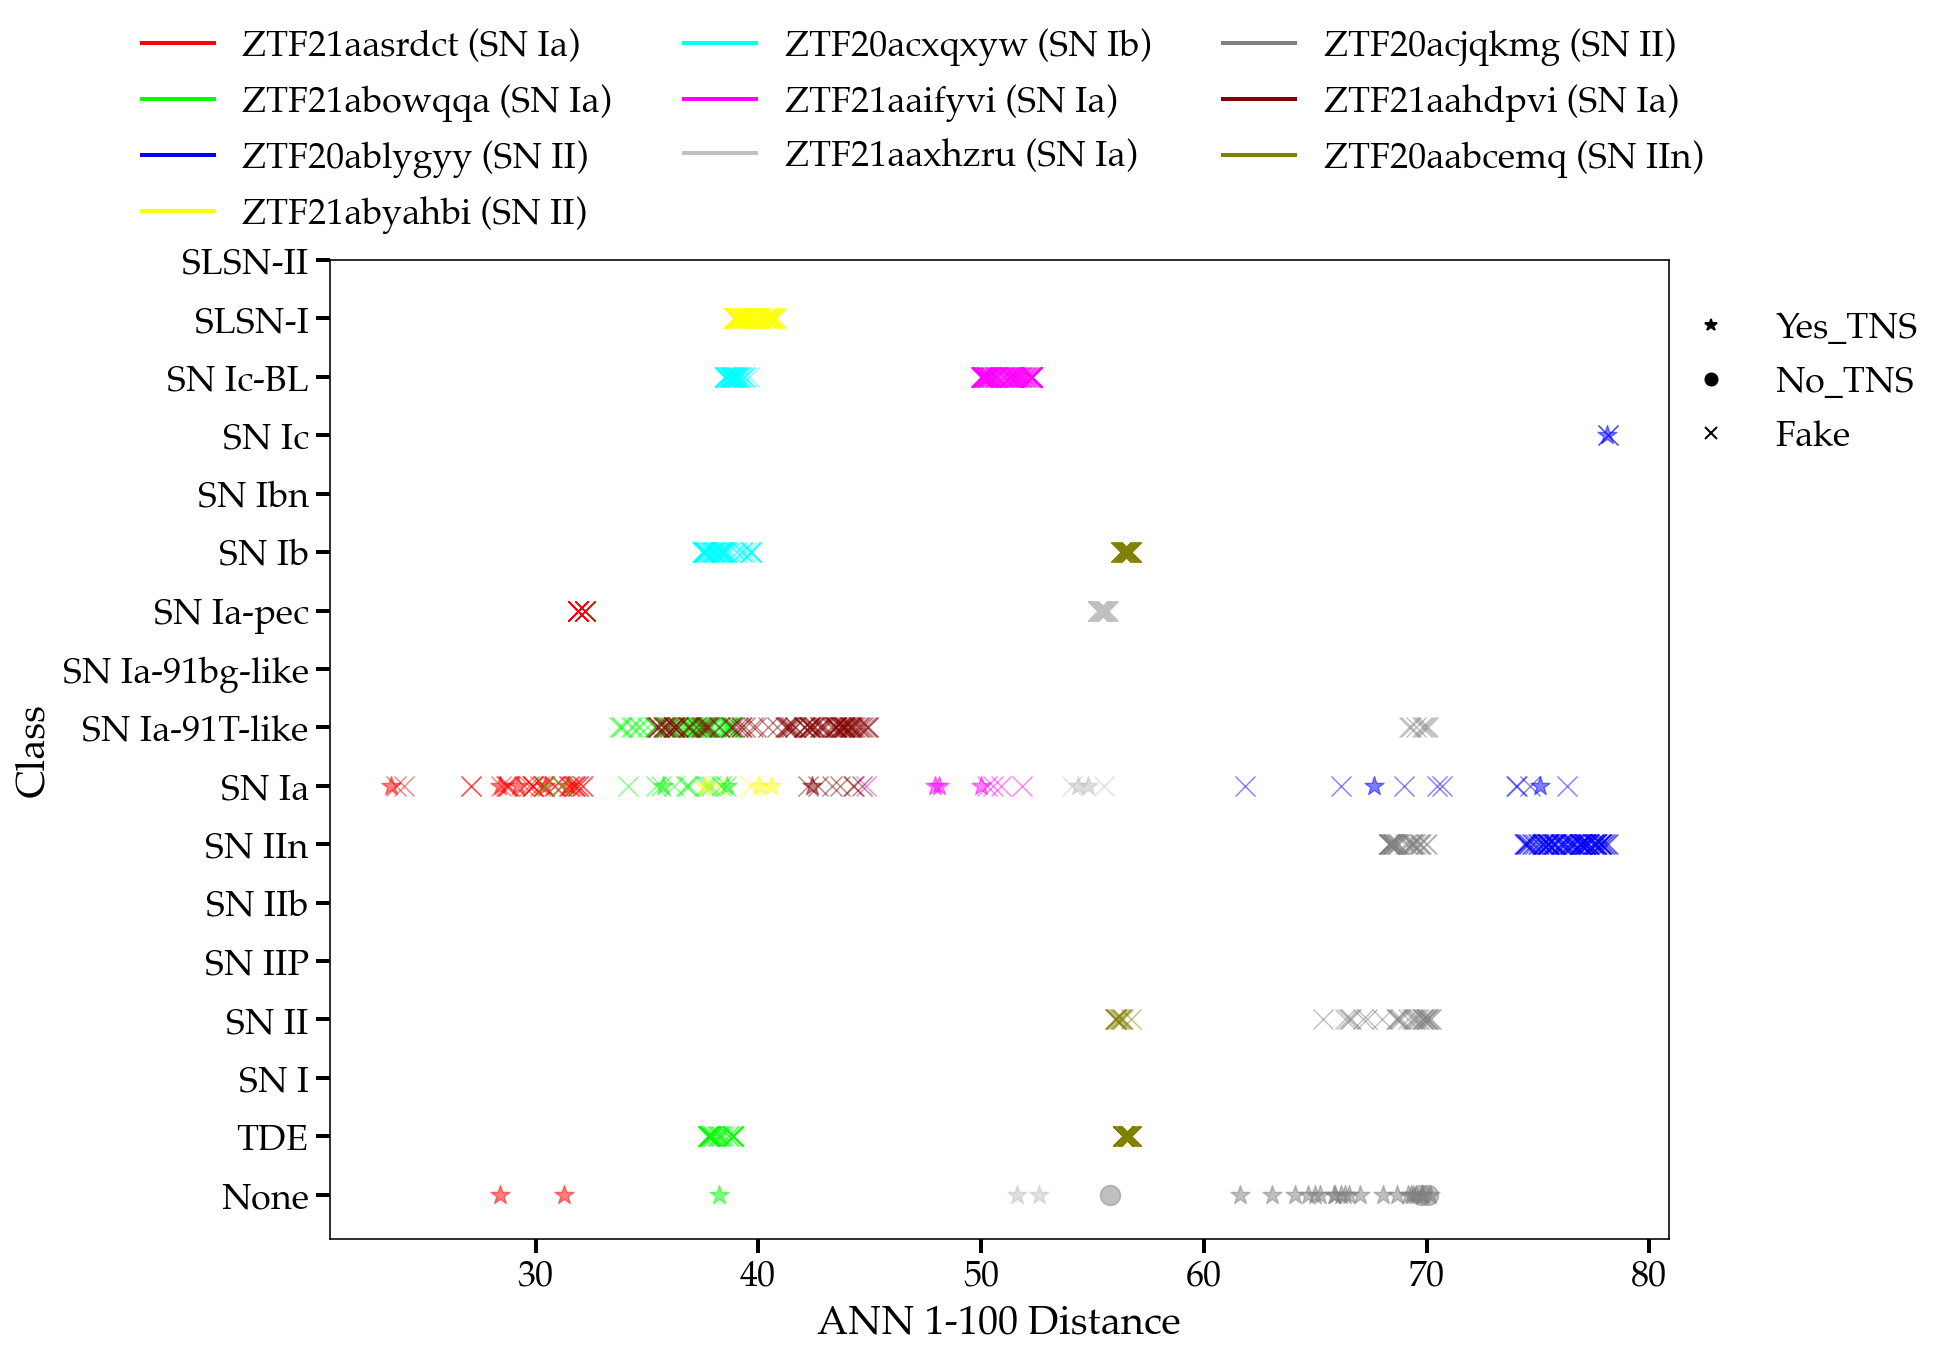

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named 'df'
ann_columns = ['{}'.format(i) for i in range(1, 101)]
distance_columns = ['ann={}_d'.format(ann) for ann in ann_columns]
class_columns = ['ann={}_tns_cls'.format(ann) for ann in ann_columns]
has_tns_columns = ['ann={}_has_tns'.format(ann) for ann in ann_columns]

spec_cls_df = full_ann_properties_df[full_ann_properties_df['ann=0_tns_cls'] != "None"]
df = spec_cls_df.sample(n=10, random_state=8)

#color_list = ['#004c6d', '#a4c2f4', '#006e51', '#87ceeb', '#9b4f0f', '#f4a460', '#d8bfd8', '#c7a317', '#808080', '#e6beff', '#f781bf', '#00ff7f', '#000000', '#808000', '#ffa500', '#7f7f7f', '#6a5acd', '#b22222', '#1e90ff', '#9932cc']
color_list = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#00FFFF', '#FF00FF', '#C0C0C0', '#808080', '#800000', '#808000', '#008000', '#800080', '#008080', '#000080', '#FFA500', '#FFC0CB', '#FFD700', '#800080', '#FF69B4', '#00CED1']


# Create the plot
fig, ax = plt.subplots(figsize=(12, 9))

# Define the order of the class labels
class_order = ['None', 'TDE', 'SN I', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-pec', 'SN Ib', 'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SLSN-I', 'SLSN-II']


color_legend_handles = {}


# Create a dictionary to map each class label to its position in the desired order
class_order_map = {'None': 0, 'TDE': 1, 'SN I': 2, 'SN II': 3, 'SN IIP': 4, 'SN IIb': 5, 'SN IIn': 6, 'SN Ia': 7, 'SN Ia-91T-like': 8, 'SN Ia-91bg-like': 9, 'SN Ia-pec': 10, 'SN Ib': 11, 'SN Ibn': 12, 'SN Ic': 13, 'SN Ic-BL': 14, 'SLSN-I': 15, 'SLSN-II': 16}
status_map = {'Yes_TNS': '*', 'No_TNS': 'o', 'Fake': 'x'}

# Iterate over the rows and plot each supernova with a different color and marker symbol
for (index_label, row), color in zip(df.iterrows(), color_list):
    # Get the ANN distances and classes for this row
    distances = row[distance_columns].values
    classes = row[class_columns].values
    #print(index_label, classes)
    ref_cls = row['ann=0_tns_cls']
    status = row[has_tns_columns].values
    #print(status)
    
    # Get the color for this supernova based on the mapping
    color = color
    
    # Sort the classes based on the desired order
    sorted_classes = [class_order_map[label] for label in classes]
    markers = [status_map[st] for st in status]
    
    #print(index_label, sorted_classes)
    for i in range(len(distances)):
        ax.scatter(distances[i], sorted_classes[i], marker=markers[i], s=100, alpha=0.5, lw=0.7, color=color)
    
    # Add the color handle to the legend dictionary
    color_legend_handles[index_label] = plt.Line2D([], [], color=color, label=f'{index_label} ({ref_cls})')

# Set the y-axis tick labels in the desired order
ax.set_yticks(list(class_order_map.values()))
ax.set_yticklabels(list(class_order_map.keys()))

# Set the axis labels and title
ax.set_xlabel('ANN 1-100 Distance')
ax.set_ylabel('Class')



# Create the color legend
color_legend = ax.legend(handles=color_legend_handles.values(), ncol=3, bbox_to_anchor=(1.05, 1.27), frameon=False)
ax.add_artist(color_legend)

# Create the marker symbol legend
marker_legend = ax.legend(handles=[plt.Line2D([], [], marker='*', color='k', linestyle='None', label='Yes_TNS'),
                                    plt.Line2D([], [], marker='o', color='k', linestyle='None', label='No_TNS'),
                                    plt.Line2D([], [], marker='x', color='k', linestyle='None', label='Fake')],
                           bbox_to_anchor=(0.98, 0.98), frameon=False)

# Show the plot
plt.savefig(f'../figures/graphs/{suffix}/ANN_vs_class.jpg', dpi=300)
plt.show()


In [41]:
df.loc['ZTF21aagkvqa']['ann=6_tns_cls']

'SN Ia-91T-like'

In [31]:
np.unique(full_ann_tns_cls_df['ann=0_tns_cls'])

array(['None', 'SLSN-I', 'SLSN-II', 'SN I', 'SN II', 'SN IIP', 'SN IIb',
       'SN IIn', 'SN Ia', 'SN Ia-91T-like', 'SN Ia-91bg-like',
       'SN Ia-pec', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'], dtype=object)

In [ ]:
['None', 'TDE', 'SN I', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-pec', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'SLSN-I', 'SLSN-II']

In [43]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'TDE']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF20acyydkh,TDE,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,...,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like,SN Ia-91T-like
ZTF21aabiipy,TDE,None,SN Ia,None,SN Ia,None,None,TDE,TDE,TDE,...,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE


In [44]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ia']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF21aaplfah,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like,SN Ia-91bg-like
ZTF21aapomdb,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec
ZTF21aahfjlo,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia-pec,SN Ia-pec,SN Ia-pec,...,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia-pec,SN Ia,SN Ia-pec,SN Ia-pec
ZTF21abcmepi,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia,SN Ia,None,SN Ia,SN Ia,...,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I
ZTF20acobamg,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,None,None,SLSN-I,SLSN-I,SLSN-I,...,SN IIn,SLSN-I,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SLSN-I,SLSN-I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20accodxy,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia,SN Ia,...,SN Ia,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN Ia,SLSN-II
ZTF21abcnkbe,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SLSN-I,SN Ia,SLSN-I,SLSN-I
ZTF21absbwyz,SN Ia,SN Ia,None,SN Ia,SN Ia,SN Ia,SN Ia,None,SN Ia,SN Ia,...,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SLSN-II,SN Ia,SN Ia,SLSN-II,SN Ia,SN Ia
ZTF21aasafkl,SN Ia,SN Ia,SN I,SN I,SN I,SN I,SN I,SN I,SN I,SN I,...,SN I,SN I,SN Ia,SN I,SN I,SN I,SN I,SN I,SN I,SN I


In [45]:
full_ann_properties_df.loc['ZTF21aahfjlo']

ann=0_ztfid       ZTF21aahfjlo
ann=1_ztfid       ZTF21aagycrc
ann=2_ztfid       ZTF20actoakx
ann=3_ztfid       ZTF21aapkhsc
ann=4_ztfid        ZTFabc96064
                      ...     
ann=96_spec_z            -99.0
ann=97_spec_z            -99.0
ann=98_spec_z            -99.0
ann=99_spec_z            -99.0
ann=100_spec_z           -99.0
Name: ZTF21aahfjlo, Length: 505, dtype: object